# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 8  
data_points_exp = 30000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$",fontsize=16)
    plt.xlabel('$y_1$',fontsize=16)
    plt.ylabel('$\\psi(y_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$y_2$',fontsize=16)
        plt.ylabel('$\\psi(0,y_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([30000, 8]), psi_samples_exp_tensor shape torch.Size([30000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 2034.8565673828125
iteration 0 loss 82.29447937011719


iteration 500 loss 0.8965540528297424


iteration 1000 loss 0.4028983414173126


iteration 1500 loss 0.24267153441905975


iteration 2000 loss 0.16561058163642883


iteration 2500 loss 0.1350678950548172


iteration 3000 loss 0.3213626444339752


iteration 3500 loss 0.10467343032360077


iteration 4000 loss 0.08601544797420502


iteration 4500 loss 0.07279612869024277


iteration 5000 loss 0.07227826118469238


iteration 5500 loss 0.061908796429634094


iteration 6000 loss 0.06368651241064072


iteration 6500 loss 0.05497664213180542


iteration 7000 loss 0.0538242943584919


iteration 7500 loss 0.116258904337883


iteration 8000 loss 0.04582914337515831


iteration 8500 loss 0.04599110409617424


iteration 9000 loss 0.0402647890150547


iteration 9500 loss 0.03973790630698204


iteration 10000 loss 0.04051072522997856


iteration 10500 loss 0.03524677827954292


iteration 11000 loss 0.03509575501084328


iteration 11500 loss 0.035435862839221954


iteration 12000 loss 0.031002836301922798


iteration 12500 loss 0.030062099918723106


iteration 13000 loss 0.029098382219672203


iteration 13500 loss 0.028032420203089714


iteration 14000 loss 0.027085214853286743


iteration 14500 loss 0.026123536750674248


iteration 15000 loss 0.025079581886529922


iteration 15500 loss 0.024367526173591614


iteration 16000 loss 0.02381402812898159


iteration 16500 loss 0.023281190544366837


iteration 17000 loss 0.02268337272107601


iteration 17500 loss 0.02205832488834858


iteration 18000 loss 0.02140781655907631


iteration 18500 loss 0.02076990157365799


iteration 19000 loss 0.020289966836571693


iteration 19500 loss 0.01984049379825592


iteration 20000 loss 0.01937250792980194


iteration 20500 loss 0.018782837316393852


iteration 21000 loss 0.01821579597890377


iteration 21500 loss 0.01773213781416416


iteration 22000 loss 0.017250878736376762


iteration 22500 loss 0.016901548951864243


iteration 23000 loss 0.016463065519928932


iteration 23500 loss 0.016129491850733757


iteration 24000 loss 0.015695560723543167


iteration 24500 loss 0.015278724953532219


iteration 25000 loss 0.08171019703149796


iteration 25500 loss 0.015691859647631645


iteration 26000 loss 0.015072932466864586


iteration 26500 loss 0.01462247222661972


iteration 27000 loss 0.0139007568359375


iteration 27500 loss 1.9385613203048706


iteration 28000 loss 0.014276030473411083


iteration 28500 loss 0.013737396337091923


iteration 29000 loss 0.013249357230961323


iteration 29500 loss 0.012860486283898354


iteration 30000 loss 0.012463212013244629


iteration 30500 loss 0.012080439366400242


iteration 31000 loss 0.6010143160820007


iteration 31500 loss 0.012975882738828659


iteration 32000 loss 0.012000944465398788


iteration 32500 loss 0.011365116573870182


iteration 33000 loss 0.7282816767692566


iteration 33500 loss 0.011216011829674244


iteration 34000 loss 0.010752101428806782


iteration 34500 loss 0.017533523961901665


iteration 35000 loss 0.010646596550941467


iteration 35500 loss 0.010286372154951096


iteration 36000 loss 0.6488178372383118


iteration 36500 loss 0.010464229620993137


iteration 37000 loss 0.010052748955786228


iteration 37500 loss 0.009759034961462021


iteration 38000 loss 0.009447216987609863


iteration 38500 loss 0.01309941615909338


iteration 39000 loss 0.009554693475365639


iteration 39500 loss 0.009269297122955322


iteration 40000 loss 0.00895398948341608


iteration 40500 loss 0.008751600049436092


iteration 41000 loss 0.00924852304160595


iteration 41500 loss 0.008767960593104362


iteration 42000 loss 0.008513390086591244


iteration 42500 loss 0.008269118145108223


iteration 43000 loss 0.008676759898662567


iteration 43500 loss 0.008355684578418732


iteration 44000 loss 0.008062463253736496


iteration 44500 loss 0.007883859798312187


iteration 45000 loss 0.012507278472185135


iteration 45500 loss 0.007927586324512959


iteration 46000 loss 0.007678970228880644


iteration 46500 loss 0.007511222269386053


iteration 47000 loss 0.007791387848556042


iteration 47500 loss 0.007466327864676714


iteration 48000 loss 0.008421460166573524


iteration 48500 loss 0.007267530541867018


iteration 49000 loss 0.007011566776782274


iteration 49500 loss 0.007465091999620199


iteration 50000 loss 0.007078835275024176


iteration 50500 loss 0.006848475895822048


iteration 51000 loss 0.04626630246639252


iteration 51500 loss 0.006683827843517065


iteration 52000 loss 0.00661964388564229


iteration 52500 loss 0.006700882222503424


iteration 53000 loss 0.006420634686946869


iteration 53500 loss 0.006533430889248848


iteration 54000 loss 0.00628844927996397


iteration 54500 loss 0.006472284905612469


iteration 55000 loss 0.006220303010195494


iteration 55500 loss 0.02755725011229515


iteration 56000 loss 0.006327458657324314


iteration 56500 loss 0.005986161530017853


iteration 57000 loss 0.006115611642599106


iteration 57500 loss 0.0059504434466362


iteration 58000 loss 0.005873950198292732


iteration 58500 loss 0.006120826117694378


iteration 59000 loss 0.005830852780491114


iteration 59500 loss 0.06649710983037949


iteration 60000 loss 0.005662251729518175


iteration 60500 loss 0.0058488985523581505


iteration 61000 loss 0.01893843151628971


iteration 61500 loss 0.00597465829923749


iteration 62000 loss 0.014685663394629955


iteration 62500 loss 0.005444489885121584


iteration 63000 loss 0.0055594970472157


iteration 63500 loss 0.00535030709579587


iteration 64000 loss 0.005194380879402161


iteration 64500 loss 0.005581954959779978


iteration 65000 loss 0.00522464606910944


iteration 65500 loss 1.3765820264816284


iteration 66000 loss 0.0052132136188447475


iteration 66500 loss 1.888749361038208


iteration 67000 loss 0.005064983852207661


iteration 67500 loss 0.005593759939074516


iteration 68000 loss 0.004951623268425465


iteration 68500 loss 0.005497762933373451


iteration 69000 loss 0.004904100671410561


iteration 69500 loss 0.1458337903022766


iteration 70000 loss 0.005088738165795803


iteration 70500 loss 0.004792851861566305


iteration 71000 loss 0.00479369331151247


iteration 71500 loss 0.004688405431807041


iteration 72000 loss 0.004647045861929655


iteration 72500 loss 0.004625225905328989


iteration 73000 loss 0.004595695994794369


iteration 73500 loss 0.004729308187961578


iteration 74000 loss 0.004528828896582127


iteration 74500 loss 0.0046955556608736515


iteration 75000 loss 0.004482000134885311


iteration 75500 loss 0.004457925446331501


iteration 76000 loss 0.004432400222867727


iteration 76500 loss 0.004468694794923067


iteration 77000 loss 0.004377052187919617


iteration 77500 loss 0.005610712803900242


iteration 78000 loss 0.02260678820312023


iteration 78500 loss 0.00429591303691268


iteration 79000 loss 0.004408148117363453


iteration 79500 loss 0.0044568185694515705


iteration 80000 loss 0.0041922698728740215


iteration 80500 loss 0.00433545233681798


iteration 81000 loss 0.004235399421304464


iteration 81500 loss 0.0043009440414607525


iteration 82000 loss 0.042157456278800964


iteration 82500 loss 0.03910427168011665


iteration 83000 loss 0.11416042596101761


iteration 83500 loss 0.004080294165760279


iteration 84000 loss 0.004209314472973347


iteration 84500 loss 0.004004300106316805


iteration 85000 loss 0.007587524596601725


iteration 85500 loss 0.11052834242582321


iteration 86000 loss 0.004097289405763149


iteration 86500 loss 0.0039727529510855675


iteration 87000 loss 0.003984176553785801


iteration 87500 loss 0.0039917114190757275


iteration 88000 loss 0.003893535351380706


iteration 88500 loss 0.004008163698017597


iteration 89000 loss 0.004488990176469088


iteration 89500 loss 0.004222327843308449


iteration 90000 loss 0.12311740219593048


iteration 90500 loss 0.941733717918396


iteration 91000 loss 0.0038070117589086294


iteration 91500 loss 0.00393027113750577


iteration 92000 loss 0.006153875961899757


iteration 92500 loss 0.003770594485104084


iteration 93000 loss 0.004152077715843916


iteration 93500 loss 0.0037179156206548214


iteration 94000 loss 0.004648488014936447


iteration 94500 loss 0.0037413376849144697


iteration 95000 loss 0.0036613834090530872


iteration 95500 loss 0.003749474650248885


iteration 96000 loss 0.003996751736849546


iteration 96500 loss 0.03495354950428009


iteration 97000 loss 0.0036629338283091784


iteration 97500 loss 0.006939250975847244


iteration 98000 loss 0.00391971692442894


iteration 98500 loss 0.003928233869373798


iteration 99000 loss 0.004063871223479509


iteration 99500 loss 0.04520507901906967


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0035835164599120617


iteration 100500 loss 0.003543846309185028


iteration 101000 loss 0.0035002261865884066


iteration 101500 loss 0.0034523766953498125


iteration 102000 loss 0.003400081302970648


iteration 102500 loss 0.003343407064676285


iteration 103000 loss 0.0032821926288306713


iteration 103500 loss 0.00321627757512033


iteration 104000 loss 0.0031455091666430235


iteration 104500 loss 0.003069693222641945


iteration 105000 loss 0.0030054235830903053


iteration 105500 loss 0.0029524806886911392


iteration 106000 loss 0.002901412546634674


iteration 106500 loss 0.002859989181160927


iteration 107000 loss 0.004677575547248125


iteration 107500 loss 0.0027794758789241314


iteration 108000 loss 0.0027404949069023132


iteration 108500 loss 0.002707012929022312


iteration 109000 loss 0.00267399987205863


iteration 109500 loss 0.0026437253691256046


iteration 110000 loss 0.0026146317832171917


iteration 110500 loss 0.0026485808193683624


iteration 111000 loss 0.002559307496994734


iteration 111500 loss 0.0025353003293275833


iteration 112000 loss 0.002510888036340475


iteration 112500 loss 0.0024888580664992332


iteration 113000 loss 0.0024674448650330305


iteration 113500 loss 0.0024473373778164387


iteration 114000 loss 0.00242744036950171


iteration 114500 loss 0.0024057303089648485


iteration 115000 loss 0.0023879753425717354


iteration 115500 loss 0.0023842891678214073


iteration 116000 loss 0.002351989969611168


iteration 116500 loss 0.0023336929734796286


iteration 117000 loss 0.0023165992461144924


iteration 117500 loss 0.002299234038218856


iteration 118000 loss 0.0022835179697722197


iteration 118500 loss 0.002339110942557454


iteration 119000 loss 0.0022522073704749346


iteration 119500 loss 0.00223732297308743


iteration 120000 loss 0.0022223845589905977


iteration 120500 loss 0.002206991193816066


iteration 121000 loss 0.0021929037757217884


iteration 121500 loss 0.002179190516471863


iteration 122000 loss 0.002165629994124174


iteration 122500 loss 0.002152498345822096


iteration 123000 loss 0.0021464757155627012


iteration 123500 loss 0.0021258892957121134


iteration 124000 loss 0.0021120025776326656


iteration 124500 loss 0.002098748693242669


iteration 125000 loss 0.0020866203121840954


iteration 125500 loss 0.0020751385018229485


iteration 126000 loss 0.0020633209496736526


iteration 126500 loss 0.0020518875680863857


iteration 127000 loss 0.0020409421995282173


iteration 127500 loss 0.002029438503086567


iteration 128000 loss 0.002018517116084695


iteration 128500 loss 0.0020071142353117466


iteration 129000 loss 0.0019962824881076813


iteration 129500 loss 0.0019856153521686792


iteration 130000 loss 0.0019745323807001114


iteration 130500 loss 0.0019639506936073303


iteration 131000 loss 0.0019541848450899124


iteration 131500 loss 0.0019443095661699772


iteration 132000 loss 0.0022268048487603664


iteration 132500 loss 0.001923852600157261


iteration 133000 loss 0.0019146859413012862


iteration 133500 loss 0.0019061589846387506


iteration 134000 loss 0.0018970617093145847


iteration 134500 loss 0.0018874661764129996


iteration 135000 loss 0.001878354582004249


iteration 135500 loss 0.0018701426452025771


iteration 136000 loss 0.0018609324470162392


iteration 136500 loss 0.0018529880326241255


iteration 137000 loss 0.0018441311549395323


iteration 137500 loss 0.0018353464547544718


iteration 138000 loss 0.0018273775931447744


iteration 138500 loss 0.007471225690096617


iteration 139000 loss 0.0018108243821188807


iteration 139500 loss 0.0018034171080216765


iteration 140000 loss 0.001795073738321662


iteration 140500 loss 0.0017877593636512756


iteration 141000 loss 0.0017795778112486005


iteration 141500 loss 0.0017718358431011438


iteration 142000 loss 0.0017639821162447333


iteration 142500 loss 0.0017559214029461145


iteration 143000 loss 0.0017481775721535087


iteration 143500 loss 0.0017415632028132677


iteration 144000 loss 0.0017341088969260454


iteration 144500 loss 0.0017268789233639836


iteration 145000 loss 0.0017198494169861078


iteration 145500 loss 0.0017127408646047115


iteration 146000 loss 0.0017057907534763217


iteration 146500 loss 0.0016992136370390654


iteration 147000 loss 0.0016914941370487213


iteration 147500 loss 0.0016844997880980372


iteration 148000 loss 0.0017422294477000833


iteration 148500 loss 0.001670884434133768


iteration 149000 loss 0.0016638244269415736


iteration 149500 loss 0.001658781198784709


iteration 150000 loss 0.0016522277146577835


iteration 150500 loss 0.001646216376684606


iteration 151000 loss 0.0016400533495470881


iteration 151500 loss 0.0016338982386514544


iteration 152000 loss 0.0016275104135274887


iteration 152500 loss 0.0016231206245720387


iteration 153000 loss 0.0016148857539519668


iteration 153500 loss 0.0019582270178943872


iteration 154000 loss 0.0016025389777496457


iteration 154500 loss 0.0015963513869792223


iteration 155000 loss 0.00159052899107337


iteration 155500 loss 0.0015861650463193655


iteration 156000 loss 0.0015797067899256945


iteration 156500 loss 0.0015744016272947192


iteration 157000 loss 0.00175399798899889


iteration 157500 loss 0.001563061960041523


iteration 158000 loss 0.0015573595883324742


iteration 158500 loss 0.0015517930733039975


iteration 159000 loss 0.0015463193412870169


iteration 159500 loss 0.0015407389728352427


iteration 160000 loss 0.0015363135607913136


iteration 160500 loss 0.0015309446025639772


iteration 161000 loss 0.0015254555037245154


iteration 161500 loss 0.0015203870134428144


iteration 162000 loss 0.0018343315459787846


iteration 162500 loss 0.0015099688898772001


iteration 163000 loss 0.0015054445248097181


iteration 163500 loss 0.001500086858868599


iteration 164000 loss 0.0014951444463804364


iteration 164500 loss 0.0014902619877830148


iteration 165000 loss 0.0014853934990242124


iteration 165500 loss 0.001480642706155777


iteration 166000 loss 0.0014761980855837464


iteration 166500 loss 0.0014710763934999704


iteration 167000 loss 0.0014667882351204753


iteration 167500 loss 0.0014628934441134334


iteration 168000 loss 0.0014578842092305422


iteration 168500 loss 0.0014537140959873796


iteration 169000 loss 0.0014488559681922197


iteration 169500 loss 0.0014445576816797256


iteration 170000 loss 0.0014405084075406194


iteration 170500 loss 0.001435640617273748


iteration 171000 loss 0.0014321537455543876


iteration 171500 loss 0.0014285342767834663


iteration 172000 loss 0.0014236565912142396


iteration 172500 loss 0.0014423049287870526


iteration 173000 loss 0.001414984930306673


iteration 173500 loss 0.0014106949092820287


iteration 174000 loss 0.006030473858118057


iteration 174500 loss 0.001404037233442068


iteration 175000 loss 0.001397792948409915


iteration 175500 loss 0.002322728279978037


iteration 176000 loss 0.0013915947638452053


iteration 176500 loss 0.0013858614256605506


iteration 177000 loss 0.0013814837438985705


iteration 177500 loss 0.001378250657580793


iteration 178000 loss 0.0013742489973083138


iteration 178500 loss 0.0013702288269996643


iteration 179000 loss 0.001366225304082036


iteration 179500 loss 0.0013626657892018557


iteration 180000 loss 0.018865831196308136


iteration 180500 loss 0.001355023356154561


iteration 181000 loss 0.0013514223974198103


iteration 181500 loss 0.001351779792457819


iteration 182000 loss 0.0013439160538837314


iteration 182500 loss 0.001339995302259922


iteration 183000 loss 0.0027382406406104565


iteration 183500 loss 0.001332117011770606


iteration 184000 loss 0.0013286498142406344


iteration 184500 loss 0.001325100427493453


iteration 185000 loss 0.0013213492929935455


iteration 185500 loss 0.0013182860566303134


iteration 186000 loss 0.001314534922130406


iteration 186500 loss 0.0013113075401633978


iteration 187000 loss 0.002627425128594041


iteration 187500 loss 0.0013037577737122774


iteration 188000 loss 0.0013005989603698254


iteration 188500 loss 0.0012977587757632136


iteration 189000 loss 0.0012940109008923173


iteration 189500 loss 0.001290548942051828


iteration 190000 loss 0.0012874382082372904


iteration 190500 loss 0.01686127670109272


iteration 191000 loss 0.001280417898669839


iteration 191500 loss 0.0012843279400840402


iteration 192000 loss 0.0012735474156215787


iteration 192500 loss 0.0029865626711398363


iteration 193000 loss 0.0012669193092733622


iteration 193500 loss 0.001263848738744855


iteration 194000 loss 0.011002324521541595


iteration 194500 loss 0.0012572815176099539


iteration 195000 loss 0.0012539169983938336


iteration 195500 loss 0.0012520606396719813


iteration 196000 loss 0.0012474521063268185


iteration 196500 loss 0.001244455692358315


iteration 197000 loss 0.001879987888969481


iteration 197500 loss 0.0012380346888676286


iteration 198000 loss 0.0012356012593954802


iteration 198500 loss 0.0035772614646703005


iteration 199000 loss 0.0012356439838185906


iteration 199500 loss 0.0012261782540008426


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0012236506445333362


iteration 200500 loss 0.001223289524205029


iteration 201000 loss 0.0012228304985910654


iteration 201500 loss 0.0012222521472722292


iteration 202000 loss 0.0012215299066156149


iteration 202500 loss 0.001220621750690043


iteration 203000 loss 0.0012194692390039563


iteration 203500 loss 0.0012180074118077755


iteration 204000 loss 0.001216149772517383


iteration 204500 loss 0.0012137857265770435


iteration 205000 loss 0.0012109680101275444


iteration 205500 loss 0.0012081091990694404


iteration 206000 loss 0.0012053166283294559


iteration 206500 loss 0.0012024727184325457


iteration 207000 loss 0.0011997231049463153


iteration 207500 loss 0.0011968250619247556


iteration 208000 loss 0.0011944420402869582


iteration 208500 loss 0.0011913987109437585


iteration 209000 loss 0.0011890496825799346


iteration 209500 loss 0.0011867264984175563


iteration 210000 loss 0.0011836022604256868


iteration 210500 loss 0.0011811493895947933


iteration 211000 loss 0.0011782709043473005


iteration 211500 loss 0.0011757239699363708


iteration 212000 loss 0.0011728808749467134


iteration 212500 loss 0.0011706878431141376


iteration 213000 loss 0.0011686224024742842


iteration 213500 loss 0.001165508758276701


iteration 214000 loss 0.0011629631044343114


iteration 214500 loss 0.0011603772873058915


iteration 215000 loss 0.001157846418209374


iteration 215500 loss 0.0011552867945283651


iteration 216000 loss 0.0011526948073878884


iteration 216500 loss 0.0011502436827868223


iteration 217000 loss 0.001147780567407608


iteration 217500 loss 0.0011451670434325933


iteration 218000 loss 0.0011430918239057064


iteration 218500 loss 0.001140438369475305


iteration 219000 loss 0.0011381381191313267


iteration 219500 loss 0.0015569789102301002


iteration 220000 loss 0.0011332626454532146


iteration 220500 loss 0.0011365165701135993


iteration 221000 loss 0.0011284975335001945


iteration 221500 loss 0.001125850947573781


iteration 222000 loss 0.0011238310253247619


iteration 222500 loss 0.0011215189006179571


iteration 223000 loss 0.0011191383237019181


iteration 223500 loss 0.0011168912751600146


iteration 224000 loss 0.0011144332820549607


iteration 224500 loss 0.0011124666780233383


iteration 225000 loss 0.0011197351850569248


iteration 225500 loss 0.0011077540693804622


iteration 226000 loss 0.001105363480746746


iteration 226500 loss 0.0011032877955585718


iteration 227000 loss 0.0011008898727595806


iteration 227500 loss 0.0010988819412887096


iteration 228000 loss 0.001096458756364882


iteration 228500 loss 0.00109441252425313


iteration 229000 loss 0.0010925553506240249


iteration 229500 loss 0.001090222503989935


iteration 230000 loss 0.0010882014175876975


iteration 230500 loss 0.0010860689217224717


iteration 231000 loss 0.0010838496964424849


iteration 231500 loss 0.001081743510439992


iteration 232000 loss 0.001079548615962267


iteration 232500 loss 0.001077301916666329


iteration 233000 loss 0.0010752864181995392


iteration 233500 loss 0.0010731910588219762


iteration 234000 loss 0.0010709394700825214


iteration 234500 loss 0.0010689462069422007


iteration 235000 loss 0.0010666995076462626


iteration 235500 loss 0.001064558164216578


iteration 236000 loss 0.0010624728165566921


iteration 236500 loss 0.0010602344991639256


iteration 237000 loss 0.0010582904797047377


iteration 237500 loss 0.0010560547234490514


iteration 238000 loss 0.001054144580848515


iteration 238500 loss 0.0014103326248005033


iteration 239000 loss 0.0010501246433705091


iteration 239500 loss 0.0010480209020897746


iteration 240000 loss 0.0010461239144206047


iteration 240500 loss 0.0010442343773320317


iteration 241000 loss 0.0010420932667329907


iteration 241500 loss 0.0010404494823887944


iteration 242000 loss 0.0010384157067164779


iteration 242500 loss 0.001036466914229095


iteration 243000 loss 0.0010342710884287953


iteration 243500 loss 0.0010326385963708162


iteration 244000 loss 0.0010306370677426457


iteration 244500 loss 0.001028781058266759


iteration 245000 loss 0.0010269201593473554


iteration 245500 loss 0.0010249591432511806


iteration 246000 loss 0.0010231181513518095


iteration 246500 loss 0.0010211467742919922


iteration 247000 loss 0.001019459217786789


iteration 247500 loss 0.0010175216011703014


iteration 248000 loss 0.0010157091310247779


iteration 248500 loss 0.0010135448537766933


iteration 249000 loss 0.0010121065424755216


iteration 249500 loss 0.001010382897220552


iteration 250000 loss 0.0010084558743983507


iteration 250500 loss 0.0010065736714750528


iteration 251000 loss 0.001004787627607584


iteration 251500 loss 0.0010031264973804355


iteration 252000 loss 0.0010011926060542464


iteration 252500 loss 0.0009995067957788706


iteration 253000 loss 0.002166676800698042


iteration 253500 loss 0.0009960874449461699


iteration 254000 loss 0.0009944572811946273


iteration 254500 loss 0.0009947270154953003


iteration 255000 loss 0.0009910410735756159


iteration 255500 loss 0.000989245716482401


iteration 256000 loss 0.0009875199757516384


iteration 256500 loss 0.0009859856218099594


iteration 257000 loss 0.001218799501657486


iteration 257500 loss 0.0009825575398281217


iteration 258000 loss 0.0009806751040741801


iteration 258500 loss 0.0009791548363864422


iteration 259000 loss 0.0009775155922397971


iteration 259500 loss 0.0009757269872352481


iteration 260000 loss 0.0009741817484609783


iteration 260500 loss 0.0009723802213557065


iteration 261000 loss 0.000970726425293833


iteration 261500 loss 0.0009690280421636999


iteration 262000 loss 0.000967423664405942


iteration 262500 loss 0.0009656969923526049


iteration 263000 loss 0.0009639331256039441


iteration 263500 loss 0.0009623991209082305


iteration 264000 loss 0.0009605997474864125


iteration 264500 loss 0.0009591414709575474


iteration 265000 loss 0.0009576956508681178


iteration 265500 loss 0.0009558791061863303


iteration 266000 loss 0.0009542847983539104


iteration 266500 loss 0.0009526722133159637


iteration 267000 loss 0.0009511714451946318


iteration 267500 loss 0.0009494586265645921


iteration 268000 loss 0.0009480406297370791


iteration 268500 loss 0.0009911101078614593


iteration 269000 loss 0.000944874482229352


iteration 269500 loss 0.0009528920636512339


iteration 270000 loss 0.0009417206747457385


iteration 270500 loss 0.0011562628205865622


iteration 271000 loss 0.000938685261644423


iteration 271500 loss 0.0009370907209813595


iteration 272000 loss 0.000935541233047843


iteration 272500 loss 0.0009339782409369946


iteration 273000 loss 0.0009324374259449542


iteration 273500 loss 0.0009309222223237157


iteration 274000 loss 0.0009293485200032592


iteration 274500 loss 0.0009279377991333604


iteration 275000 loss 0.0009263106039725244


iteration 275500 loss 0.0009249381837435067


iteration 276000 loss 0.0009284622501581907


iteration 276500 loss 0.0009219374624080956


iteration 277000 loss 0.0009202591609209776


iteration 277500 loss 0.0009190106648020446


iteration 278000 loss 0.0009175736922770739


iteration 278500 loss 0.0009159798501059413


iteration 279000 loss 0.0009146797237917781


iteration 279500 loss 0.0009131655679084361


iteration 280000 loss 0.0009116972796618938


iteration 280500 loss 0.0009102540207095444


iteration 281000 loss 0.0009088842780329287


iteration 281500 loss 0.0009073657565750182


iteration 282000 loss 0.0009061113814823329


iteration 282500 loss 0.0009046205668710172


iteration 283000 loss 0.0009032213129103184


iteration 283500 loss 0.0009016252006404102


iteration 284000 loss 0.0009004034800454974


iteration 284500 loss 0.0008990975911729038


iteration 285000 loss 0.0008975822711363435


iteration 285500 loss 0.0008961819694377482


iteration 286000 loss 0.0008947381284087896


iteration 286500 loss 0.0008934258949011564


iteration 287000 loss 0.0008958083344623446


iteration 287500 loss 0.000890711322426796


iteration 288000 loss 0.0008892688201740384


iteration 288500 loss 0.0008879582746885717


iteration 289000 loss 0.0008866388816386461


iteration 289500 loss 0.0008851654129102826


iteration 290000 loss 0.0008839961956255138


iteration 290500 loss 0.0008825379773043096


iteration 291000 loss 0.0008812472806312144


iteration 291500 loss 0.0013702675933018327


iteration 292000 loss 0.0008785029058344662


iteration 292500 loss 0.0008774682064540684


iteration 293000 loss 0.0008758493349887431


iteration 293500 loss 0.0008746288949623704


iteration 294000 loss 0.0008731882553547621


iteration 294500 loss 0.0008719181641936302


iteration 295000 loss 0.0008705239742994308


iteration 295500 loss 0.0008693053387105465


iteration 296000 loss 0.0008679108577780426


iteration 296500 loss 0.0008665383793413639


iteration 297000 loss 0.0008652341202832758


iteration 297500 loss 0.0008638569852337241


iteration 298000 loss 0.0008624736801721156


iteration 298500 loss 0.0008612759993411601


iteration 299000 loss 0.0008599787252023816


iteration 299500 loss 0.0008586952462792397


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.000857372535392642


iteration 300500 loss 0.0008572153165005147


iteration 301000 loss 0.0008570011123083532


iteration 301500 loss 0.0008567204349674284


iteration 302000 loss 0.0008563624578528106


iteration 302500 loss 0.0008559053530916572


iteration 303000 loss 0.0008553183870390058


iteration 303500 loss 0.0008545665768906474


iteration 304000 loss 0.0008536094683222473


iteration 304500 loss 0.0008523862343281507


iteration 305000 loss 0.0008509074687026441


iteration 305500 loss 0.0008499203249812126


iteration 306000 loss 0.0008486889419145882


iteration 306500 loss 0.0008472561603412032


iteration 307000 loss 0.0008462633122690022


iteration 307500 loss 0.0008450017776340246


iteration 308000 loss 0.0008436581119894981


iteration 308500 loss 0.0008426627609878778


iteration 309000 loss 0.0008413891191594303


iteration 309500 loss 0.0008401090744882822


iteration 310000 loss 0.0008390395087189972


iteration 310500 loss 0.0008376710466109216


iteration 311000 loss 0.0008365617250092328


iteration 311500 loss 0.0008353840094059706


iteration 312000 loss 0.0008340264903381467


iteration 312500 loss 0.0008330317214131355


iteration 313000 loss 0.000831766112241894


iteration 313500 loss 0.000830567441880703


iteration 314000 loss 0.000829547003377229


iteration 314500 loss 0.0008282468770630658


iteration 315000 loss 0.0008271471597254276


iteration 315500 loss 0.0008260353351943195


iteration 316000 loss 0.0008246240904554725


iteration 316500 loss 0.0008237415459007025


iteration 317000 loss 0.0008226452628150582


iteration 317500 loss 0.0008214119588956237


iteration 318000 loss 0.0008203518809750676


iteration 318500 loss 0.0008191897650249302


iteration 319000 loss 0.0008179393480531871


iteration 319500 loss 0.0008169910870492458


iteration 320000 loss 0.0008157818811014295


iteration 320500 loss 0.0008146038162522018


iteration 321000 loss 0.000813604798167944


iteration 321500 loss 0.000812336103990674


iteration 322000 loss 0.0008113005314953625


iteration 322500 loss 0.0008101836428977549


iteration 323000 loss 0.0008089437033049762


iteration 323500 loss 0.0008080327534116805


iteration 324000 loss 0.0008068671450018883


iteration 324500 loss 0.0008056985680013895


iteration 325000 loss 0.0008048206800594926


iteration 325500 loss 0.000803693663328886


iteration 326000 loss 0.0008024839917197824


iteration 326500 loss 0.0008016122155822814


iteration 327000 loss 0.0008004955598153174


iteration 327500 loss 0.0007993397885002196


iteration 328000 loss 0.0007984020048752427


iteration 328500 loss 0.0007972047314979136


iteration 329000 loss 0.0007961841183714569


iteration 329500 loss 0.0007952065789140761


iteration 330000 loss 0.0007939603528939188


iteration 330500 loss 0.00079307024134323


iteration 331000 loss 0.0007920587086118758


iteration 331500 loss 0.0007907798863016069


iteration 332000 loss 0.0007899775519035757


iteration 332500 loss 0.0007890064734965563


iteration 333000 loss 0.0007877740426920354


iteration 333500 loss 0.0007869186229072511


iteration 334000 loss 0.0007860074983909726


iteration 334500 loss 0.0007848439854569733


iteration 335000 loss 0.0007839002064429224


iteration 335500 loss 0.0007830254035070539


iteration 336000 loss 0.0007819097954779863


iteration 336500 loss 0.0007808911614120007


iteration 337000 loss 0.0007800352177582681


iteration 337500 loss 0.0007789444061927497


iteration 338000 loss 0.0007779212901368737


iteration 338500 loss 0.000777038570959121


iteration 339000 loss 0.0007759181316941977


iteration 339500 loss 0.0007749670767225325


iteration 340000 loss 0.0007740332512184978


iteration 340500 loss 0.0007728360360488296


iteration 341000 loss 0.0007720558205619454


iteration 341500 loss 0.000771129154600203


iteration 342000 loss 0.0007699465495534241


iteration 342500 loss 0.0007691438077017665


iteration 343000 loss 0.0007681643473915756


iteration 343500 loss 0.0007670287159271538


iteration 344000 loss 0.0007662886637263


iteration 344500 loss 0.0007653367356397212


iteration 345000 loss 0.0007645127479918301


iteration 345500 loss 0.0007634387002326548


iteration 346000 loss 0.0007625044672749937


iteration 346500 loss 0.0007616668590344489


iteration 347000 loss 0.0007606103317812085


iteration 347500 loss 0.0007596989162266254


iteration 348000 loss 0.0007585375569760799


iteration 348500 loss 0.000757804315071553


iteration 349000 loss 0.0007569246226921678


iteration 349500 loss 0.0007557968492619693


iteration 350000 loss 0.00075504370033741


iteration 350500 loss 0.0007541837403550744


iteration 351000 loss 0.0007530834409408271


iteration 351500 loss 0.0007522641099058092


iteration 352000 loss 0.0007513948949053884


iteration 352500 loss 0.0007502881344407797


iteration 353000 loss 0.0007495310273952782


iteration 353500 loss 0.0007486750837415457


iteration 354000 loss 0.0007475868333131075


iteration 354500 loss 0.0007468124385923147


iteration 355000 loss 0.0007459504413418472


iteration 355500 loss 0.0007448505493812263


iteration 356000 loss 0.0007441318593919277


iteration 356500 loss 0.000743264623451978


iteration 357000 loss 0.0007431042031385005


iteration 357500 loss 0.0007414305000565946


iteration 358000 loss 0.0007404859643429518


iteration 358500 loss 0.0007395108696073294


iteration 359000 loss 0.0007387998048216105


iteration 359500 loss 0.0007378936279565096


iteration 360000 loss 0.0007368427468463778


iteration 360500 loss 0.0007361553725786507


iteration 361000 loss 0.0007352716056630015


iteration 361500 loss 0.0007342312019318342


iteration 362000 loss 0.0007335870177485049


iteration 362500 loss 0.0007327746716327965


iteration 363000 loss 0.0007317394483834505


iteration 363500 loss 0.0007310023065656424


iteration 364000 loss 0.0007301855366677046


iteration 364500 loss 0.00072914530755952


iteration 365000 loss 0.0007284533930942416


iteration 365500 loss 0.0007276517571881413


iteration 366000 loss 0.0007266345783136785


iteration 366500 loss 0.0007258851546794176


iteration 367000 loss 0.0007250407361425459


iteration 367500 loss 0.0007240524864755571


iteration 368000 loss 0.0007233804790303111


iteration 368500 loss 0.0007225830340757966


iteration 369000 loss 0.0007215634104795754


iteration 369500 loss 0.0007208831957541406


iteration 370000 loss 0.0007201205007731915


iteration 370500 loss 0.0007191437762230635


iteration 371000 loss 0.0007184069254435599


iteration 371500 loss 0.0007176473154686391


iteration 372000 loss 0.0007166822906583548


iteration 372500 loss 0.0007159620290622115


iteration 373000 loss 0.0007152189500629902


iteration 373500 loss 0.0007142727845348418


iteration 374000 loss 0.0007135127088986337


iteration 374500 loss 0.0007126350537873805


iteration 375000 loss 0.0007117350469343364


iteration 375500 loss 0.0007111236918717623


iteration 376000 loss 0.0007103448733687401


iteration 376500 loss 0.0007093774038366973


iteration 377000 loss 0.0007087143021635711


iteration 377500 loss 0.00070792535552755


iteration 378000 loss 0.0007113437750376761


iteration 378500 loss 0.0007063406519591808


iteration 379000 loss 0.0007056008907966316


iteration 379500 loss 0.0007046569953672588


iteration 380000 loss 0.0007039670599624515


iteration 380500 loss 0.0007032583234831691


iteration 381000 loss 0.0007023544749245048


iteration 381500 loss 0.0007016093004494905


iteration 382000 loss 0.0007009090622887015


iteration 382500 loss 0.0007000166806392372


iteration 383000 loss 0.0006992907146923244


iteration 383500 loss 0.0006986456573940814


iteration 384000 loss 0.0006978182354941964


iteration 384500 loss 0.0006970081594772637


iteration 385000 loss 0.0006963346968404949


iteration 385500 loss 0.0006954767741262913


iteration 386000 loss 0.0006947258953005075


iteration 386500 loss 0.0006940541206859052


iteration 387000 loss 0.0006931974203325808


iteration 387500 loss 0.0006924461340531707


iteration 388000 loss 0.0006917980499565601


iteration 388500 loss 0.0006909700459800661


iteration 389000 loss 0.0006901390152052045


iteration 389500 loss 0.0006895335391163826


iteration 390000 loss 0.0006887629861012101


iteration 390500 loss 0.0006878504063934088


iteration 391000 loss 0.0006873001111671329


iteration 391500 loss 0.0006865967880003154


iteration 392000 loss 0.0006857007974758744


iteration 392500 loss 0.0006850851350463927


iteration 393000 loss 0.0006844693562015891


iteration 393500 loss 0.0006836766842752695


iteration 394000 loss 0.00068286171881482


iteration 394500 loss 0.0006822916911914945


iteration 395000 loss 0.0006815633387304842


iteration 395500 loss 0.0006807329482398927


iteration 396000 loss 0.0006801151903346181


iteration 396500 loss 0.0006794053479097784


iteration 397000 loss 0.0006785010336898267


iteration 397500 loss 0.0006779337418265641


iteration 398000 loss 0.0006772628403268754


iteration 398500 loss 0.0006764056161046028


iteration 399000 loss 0.0006757882656529546


iteration 399500 loss 0.0006752066547051072


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0006744678830727935


iteration 400500 loss 0.0006743861013092101


iteration 401000 loss 0.000674274459015578


iteration 401500 loss 0.000674121081829071


iteration 402000 loss 0.0006739257951267064


iteration 402500 loss 0.0006736746290698647


iteration 403000 loss 0.0006733679911121726


iteration 403500 loss 0.000672987662255764


iteration 404000 loss 0.0006725171697326005


iteration 404500 loss 0.0006719468510709703


iteration 405000 loss 0.0006712658214382827


iteration 405500 loss 0.0006705261766910553


iteration 406000 loss 0.0006697867065668106


iteration 406500 loss 0.0006690513691864908


iteration 407000 loss 0.000668305263388902


iteration 407500 loss 0.0006675675977021456


iteration 408000 loss 0.0006668306305073202


iteration 408500 loss 0.0006661009392701089


iteration 409000 loss 0.0006653664750047028


iteration 409500 loss 0.0006646398105658591


iteration 410000 loss 0.0006639110506512225


iteration 410500 loss 0.0006631844444200397


iteration 411000 loss 0.000662460457533598


iteration 411500 loss 0.0006617408944293857


iteration 412000 loss 0.0006610222044400871


iteration 412500 loss 0.000660303863696754


iteration 413000 loss 0.0006595931481570005


iteration 413500 loss 0.0006588790565729141


iteration 414000 loss 0.0006581680499948561


iteration 414500 loss 0.000657459779176861


iteration 415000 loss 0.0006567541277036071


iteration 415500 loss 0.0006560516194440424


iteration 416000 loss 0.0006553478306159377


iteration 416500 loss 0.000654650095384568


iteration 417000 loss 0.0006539511377923191


iteration 417500 loss 0.0006532545667141676


iteration 418000 loss 0.0006525659118779004


iteration 418500 loss 0.0006518751615658402


iteration 419000 loss 0.0006511874962598085


iteration 419500 loss 0.0006505099008791149


iteration 420000 loss 0.0006498260772787035


iteration 420500 loss 0.0006491485401056707


iteration 421000 loss 0.0006484630866907537


iteration 421500 loss 0.0006477896240539849


iteration 422000 loss 0.0006471095839515328


iteration 422500 loss 0.0006464353064075112


iteration 423000 loss 0.0006457587005570531


iteration 423500 loss 0.0006451059016399086


iteration 424000 loss 0.000644443673081696


iteration 424500 loss 0.0006437712581828237


iteration 425000 loss 0.0006431007641367614


iteration 425500 loss 0.0006424412131309509


iteration 426000 loss 0.0006417852127924562


iteration 426500 loss 0.00064112339168787


iteration 427000 loss 0.0006404616287909448


iteration 427500 loss 0.0006398051045835018


iteration 428000 loss 0.0006391523638740182


iteration 428500 loss 0.0006385002052411437


iteration 429000 loss 0.0006378418765962124


iteration 429500 loss 0.0006371852359734476


iteration 430000 loss 0.0006365294102579355


iteration 430500 loss 0.0006358764949254692


iteration 431000 loss 0.0006352265481837094


iteration 431500 loss 0.0006345773581415415


iteration 432000 loss 0.0006339294486679137


iteration 432500 loss 0.0006332828779704869


iteration 433000 loss 0.0006326379370875657


iteration 433500 loss 0.0006319937529042363


iteration 434000 loss 0.00063135358504951


iteration 434500 loss 0.0006307106814347208


iteration 435000 loss 0.0006300720269791782


iteration 435500 loss 0.0006294325576163828


iteration 436000 loss 0.0006287973956204951


iteration 436500 loss 0.0006281627574935555


iteration 437000 loss 0.0006275299238041043


iteration 437500 loss 0.0006268966826610267


iteration 438000 loss 0.0006262688548304141


iteration 438500 loss 0.0006256402120925486


iteration 439000 loss 0.0006250101141631603


iteration 439500 loss 0.0006243871175684035


iteration 440000 loss 0.0006237608613446355


iteration 440500 loss 0.0006231397273950279


iteration 441000 loss 0.0006225183024071157


iteration 441500 loss 0.0006218957132659853


iteration 442000 loss 0.0006212767329998314


iteration 442500 loss 0.0006206593243405223


iteration 443000 loss 0.0006200438365340233


iteration 443500 loss 0.0006194272427819669


iteration 444000 loss 0.0006188167608343065


iteration 444500 loss 0.0006182021461427212


iteration 445000 loss 0.0006175906164571643


iteration 445500 loss 0.0006169800763018429


iteration 446000 loss 0.0006163736688904464


iteration 446500 loss 0.0006157666794024408


iteration 447000 loss 0.0006151609122753143


iteration 447500 loss 0.0006145535735413432


iteration 448000 loss 0.0006139539182186127


iteration 448500 loss 0.0006133504793979228


iteration 449000 loss 0.0006127505330368876


iteration 449500 loss 0.0006121512269601226


iteration 450000 loss 0.0006115527357906103


iteration 450500 loss 0.0006109578534960747


iteration 451000 loss 0.0006103629129938781


iteration 451500 loss 0.0006097700097598135


iteration 452000 loss 0.0006091801915317774


iteration 452500 loss 0.000608589849434793


iteration 453000 loss 0.0006080022430978715


iteration 453500 loss 0.0006074121920391917


iteration 454000 loss 0.000606832152698189


iteration 454500 loss 0.0006062418688088655


iteration 455000 loss 0.000605658337008208


iteration 455500 loss 0.0006050759111531079


iteration 456000 loss 0.0006044941837899387


iteration 456500 loss 0.0006039140280336142


iteration 457000 loss 0.0006033366080373526


iteration 457500 loss 0.0006027557537890971


iteration 458000 loss 0.0006021804292686284


iteration 458500 loss 0.0006016070838086307


iteration 459000 loss 0.0006010307115502656


iteration 459500 loss 0.0006004569004289806


iteration 460000 loss 0.0005998928099870682


iteration 460500 loss 0.0005993213271722198


iteration 461000 loss 0.0005987496697343886


iteration 461500 loss 0.000598180282395333


iteration 462000 loss 0.0005976133979856968


iteration 462500 loss 0.0005970469210296869


iteration 463000 loss 0.0005964798619970679


iteration 463500 loss 0.000595914083532989


iteration 464000 loss 0.0005953517975285649


iteration 464500 loss 0.0005947877070866525


iteration 465000 loss 0.0005942271091043949


iteration 465500 loss 0.0005936707020737231


iteration 466000 loss 0.0005931108025833964


iteration 466500 loss 0.000592551426962018


iteration 467000 loss 0.0005919968825764954


iteration 467500 loss 0.0005914398352615535


iteration 468000 loss 0.0005908870953135192


iteration 468500 loss 0.0005903334822505713


iteration 469000 loss 0.0005897821974940598


iteration 469500 loss 0.0005892316694371402


iteration 470000 loss 0.0005886837025173008


iteration 470500 loss 0.000588133349083364


iteration 471000 loss 0.0005875832866877317


iteration 471500 loss 0.0005870400927960873


iteration 472000 loss 0.0005864950944669545


iteration 472500 loss 0.0005859514931216836


iteration 473000 loss 0.0005854071350768209


iteration 473500 loss 0.000584867550060153


iteration 474000 loss 0.0005843280232511461


iteration 474500 loss 0.0005837870994582772


iteration 475000 loss 0.000583252462092787


iteration 475500 loss 0.000582712353207171


iteration 476000 loss 0.0005821769591420889


iteration 476500 loss 0.0005816415068693459


iteration 477000 loss 0.0005811091978102922


iteration 477500 loss 0.0005805741529911757


iteration 478000 loss 0.0005800472572445869


iteration 478500 loss 0.0005795167526230216


iteration 479000 loss 0.0005789882852695882


iteration 479500 loss 0.000578457023948431


iteration 480000 loss 0.0005779374623671174


iteration 480500 loss 0.0005774066084995866


iteration 481000 loss 0.0005768908304162323


iteration 481500 loss 0.0005763671942986548


iteration 482000 loss 0.0005758475163020194


iteration 482500 loss 0.0005753279547207057


iteration 483000 loss 0.0005748053081333637


iteration 483500 loss 0.000574292556848377


iteration 484000 loss 0.0005737754981964827


iteration 484500 loss 0.0005732622230425477


iteration 485000 loss 0.0005727459210902452


iteration 485500 loss 0.0005722311325371265


iteration 486000 loss 0.000571729673538357


iteration 486500 loss 0.0005712177371606231


iteration 487000 loss 0.0005707041709683836


iteration 487500 loss 0.0005701909540221095


iteration 488000 loss 0.0005696859443560243


iteration 488500 loss 0.0005691746482625604


iteration 489000 loss 0.0005686673684976995


iteration 489500 loss 0.0005681727197952569


iteration 490000 loss 0.0005676724249497056


iteration 490500 loss 0.0005671803955920041


iteration 491000 loss 0.0005666748038493097


iteration 491500 loss 0.0005661834729835391


iteration 492000 loss 0.000565680384170264


iteration 492500 loss 0.000565173861104995


iteration 493000 loss 0.0005646690260618925


iteration 493500 loss 0.0005641704774461687


iteration 494000 loss 0.00056366779608652


iteration 494500 loss 0.0005631661042571068


iteration 495000 loss 0.000562665518373251


iteration 495500 loss 0.0005621662712655962


iteration 496000 loss 0.0005616688868030906


iteration 496500 loss 0.0005611747037619352


iteration 497000 loss 0.0005606796476058662


iteration 497500 loss 0.0005601834855042398


iteration 498000 loss 0.0005596883711405098


iteration 498500 loss 0.0005591957014985383


iteration 499000 loss 0.0005587005871348083


iteration 499500 loss 0.0005582082667388022


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=8) ---
loss 80.05606079101562


loss 0.9391649961471558


loss -42.81398010253906


loss -65.29801940917969


loss -75.32638549804688


loss -79.01832580566406


loss -80.07623291015625


loss -80.29537963867188


loss -80.32523345947266


loss -80.32760620117188


loss -80.32770538330078


loss -80.32770538330078


loss -80.32771301269531


loss -80.32771301269531


loss -80.32770538330078


loss -80.32771301269531


loss -80.32770538330078


loss -80.32770538330078


loss -80.32770538330078


loss -80.32770538330078


loss -80.32771301269531


loss -80.32771301269531


loss -80.32771301269531


loss -80.32770538330078


loss -80.32771301269531


loss -80.32770538330078


loss -80.32770538330078


loss -80.32771301269531


loss -80.32771301269531


loss -80.32771301269531


loss -80.32771301269531


loss -80.32770538330078


loss -80.32771301269531


loss -80.32771301269531


loss -80.32771301269531


loss -80.32770538330078


loss -80.32771301269531


loss -80.32771301269531


loss -80.32771301269531


loss -80.32771301269531


final mse:  2.1863182375625456e-09
max, min: 2.1004448 -2.1339905
loss 80.05606079101562


loss 1.4018409252166748


loss -42.43864059448242


loss -64.90985107421875


loss -74.82560729980469


loss -78.41450500488281


loss -79.42253112792969


loss -79.62661743164062


loss -79.65364074707031


loss -79.65570831298828


loss -79.65579223632812


loss -79.6557846069336


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


loss -79.6557846069336


loss -79.65579223632812


loss -79.65579223632812


loss -79.6557846069336


loss -79.65579223632812


loss -79.65579223632812


loss -79.65579223632812


final mse:  2.4058044445496307e-09
max, min: 2.0724187 -2.138194


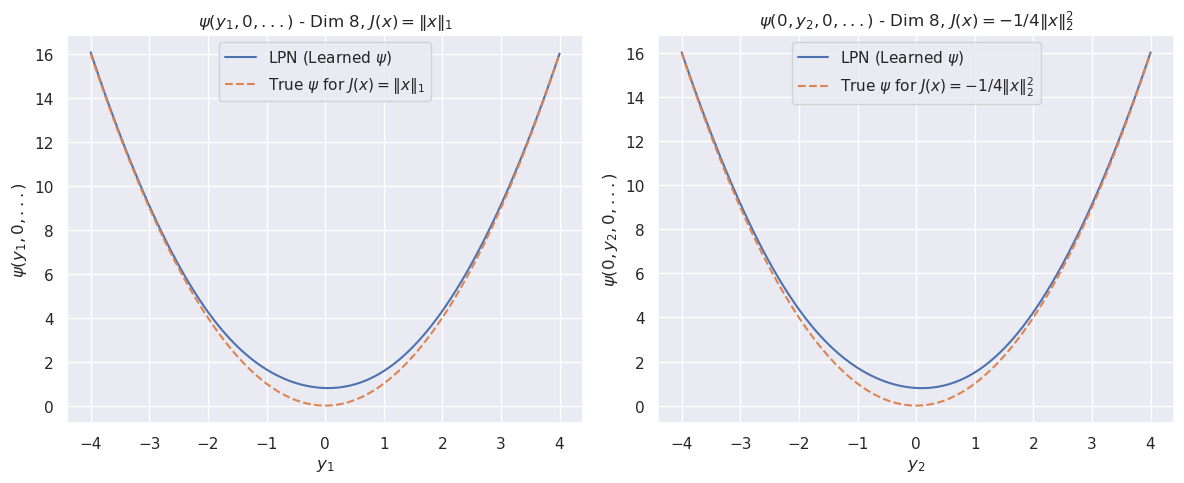

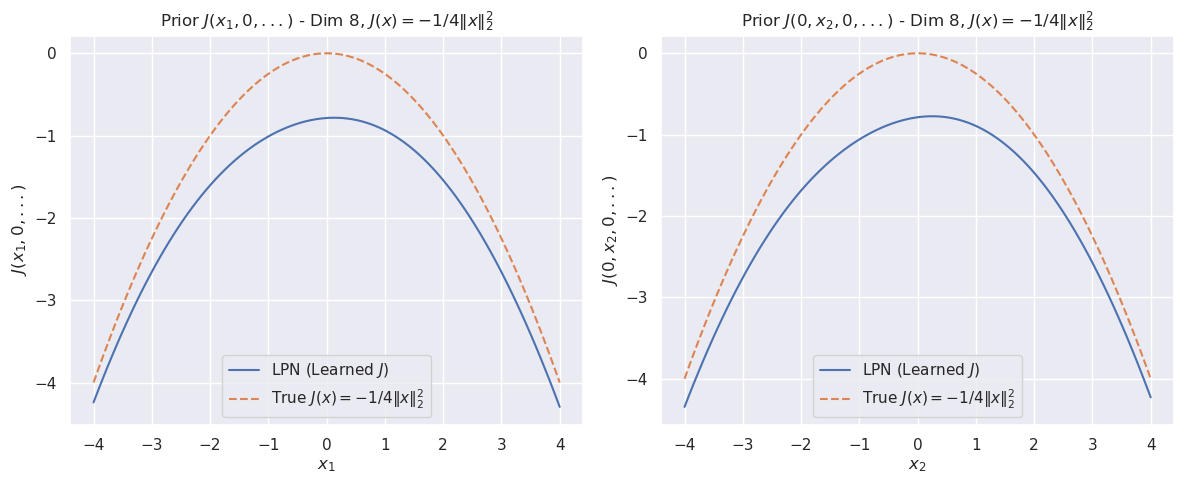

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


tensor([[-1.3647,  3.5380, -7.9022,  ..., -6.4605, -4.9723, -2.4844],
        [-1.6714,  0.6369, -1.3095,  ...,  5.9923, -7.6419,  2.7149],
        [-1.2964,  0.9107, -5.7901,  ...,  7.4949, -2.9985,  3.0820],
        ...,
        [ 1.2160, -0.3702,  0.4290,  ..., -3.7395, -6.4615, -0.9248],
        [-0.2720, -0.9692, -5.5478,  ...,  7.4779, -5.7646, -5.8544],
        [ 0.8322, -6.2438, -3.7894,  ...,  2.1287,  0.3933,  6.4109]],
       device='cuda:0')

In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 2005.041015625
iteration 0 loss 1151.1844482421875


iteration 500 loss 37.97197723388672


iteration 1000 loss 1.9675971269607544


iteration 1500 loss 0.7232065200805664


iteration 2000 loss 0.37730610370635986


iteration 2500 loss 0.4464060068130493


iteration 3000 loss 0.22407571971416473


iteration 3500 loss 0.1664489060640335


iteration 4000 loss 0.13094282150268555


iteration 4500 loss 0.14108063280582428


iteration 5000 loss 0.10884826630353928


iteration 5500 loss 0.1209997609257698


iteration 6000 loss 0.08450516313314438


iteration 6500 loss 0.07735668122768402


iteration 7000 loss 0.0700051337480545


iteration 7500 loss 0.06456328928470612


iteration 8000 loss 1.8466445207595825


iteration 8500 loss 0.0610099695622921


iteration 9000 loss 0.056422263383865356


iteration 9500 loss 0.05221701040863991


iteration 10000 loss 0.04881138727068901


iteration 10500 loss 0.0459728017449379


iteration 11000 loss 0.043610185384750366


iteration 11500 loss 0.04236576333642006


iteration 12000 loss 0.048132363706827164


iteration 12500 loss 0.04111723601818085


iteration 13000 loss 0.03816958889365196


iteration 13500 loss 0.03595145046710968


iteration 14000 loss 0.034240495413541794


iteration 14500 loss 1.3180630207061768


iteration 15000 loss 0.035276979207992554


iteration 15500 loss 0.03312569856643677


iteration 16000 loss 0.030900118872523308


iteration 16500 loss 0.029184997081756592


iteration 17000 loss 0.02765835076570511


iteration 17500 loss 0.3030221462249756


iteration 18000 loss 0.03215271607041359


iteration 18500 loss 0.027030616998672485


iteration 19000 loss 0.025420501828193665


iteration 19500 loss 0.024228978902101517


iteration 20000 loss 0.02315385453402996


iteration 20500 loss 0.024668673053383827


iteration 21000 loss 0.022856581956148148


iteration 21500 loss 0.021742960438132286


iteration 22000 loss 0.020815901458263397


iteration 22500 loss 0.04861074313521385


iteration 23000 loss 0.020863590762019157


iteration 23500 loss 0.01965334638953209


iteration 24000 loss 0.0189038198441267


iteration 24500 loss 0.023426886647939682


iteration 25000 loss 0.018848584964871407


iteration 25500 loss 0.017957432195544243


iteration 26000 loss 0.01713070087134838


iteration 26500 loss 0.024857550859451294


iteration 27000 loss 0.017141496762633324


iteration 27500 loss 0.016265423968434334


iteration 28000 loss 0.015670936554670334


iteration 28500 loss 0.15225934982299805


iteration 29000 loss 0.016207506880164146


iteration 29500 loss 0.015262969769537449


iteration 30000 loss 0.0146095622330904


iteration 30500 loss 0.014128967188298702


iteration 31000 loss 0.021788179874420166


iteration 31500 loss 0.013941086828708649


iteration 32000 loss 0.013313030824065208


iteration 32500 loss 0.08404555171728134


iteration 33000 loss 0.013240477070212364


iteration 33500 loss 0.01273559220135212


iteration 34000 loss 0.01227862760424614


iteration 34500 loss 0.0124905901029706


iteration 35000 loss 0.011845781467854977


iteration 35500 loss 0.0120262261480093


iteration 36000 loss 0.015188300982117653


iteration 36500 loss 0.011393235065042973


iteration 37000 loss 0.0108595360070467


iteration 37500 loss 0.04613346979022026


iteration 38000 loss 0.010884677991271019


iteration 38500 loss 0.010411110706627369


iteration 39000 loss 2.4464969635009766


iteration 39500 loss 0.01039936114102602


iteration 40000 loss 0.00989368837326765


iteration 40500 loss 0.017900187522172928


iteration 41000 loss 0.0097688352689147


iteration 41500 loss 0.009254575707018375


iteration 42000 loss 0.009271909482777119


iteration 42500 loss 0.009203704074025154


iteration 43000 loss 0.01074536144733429


iteration 43500 loss 0.00881956797093153


iteration 44000 loss 0.016560301184654236


iteration 44500 loss 0.008531048893928528


iteration 45000 loss 0.010894744656980038


iteration 45500 loss 0.00833088532090187


iteration 46000 loss 0.008033184334635735


iteration 46500 loss 0.05534115433692932


iteration 47000 loss 0.008074065670371056


iteration 47500 loss 0.019465846940875053


iteration 48000 loss 0.007617373950779438


iteration 48500 loss 0.007676592096686363


iteration 49000 loss 0.007454005070030689


iteration 49500 loss 0.007261517457664013


iteration 50000 loss 0.007194916717708111


iteration 50500 loss 0.007218058221042156


iteration 51000 loss 0.746842086315155


iteration 51500 loss 0.007154948078095913


iteration 52000 loss 0.007144555915147066


iteration 52500 loss 0.006725805811583996


iteration 53000 loss 0.006812374573200941


iteration 53500 loss 0.5084204077720642


iteration 54000 loss 0.006494871806353331


iteration 54500 loss 0.00652866717427969


iteration 55000 loss 0.4525582790374756


iteration 55500 loss 0.006379229016602039


iteration 56000 loss 0.03064647689461708


iteration 56500 loss 0.015029771253466606


iteration 57000 loss 0.6939245462417603


iteration 57500 loss 0.006016982719302177


iteration 58000 loss 0.006187390070408583


iteration 58500 loss 0.005927516613155603


iteration 59000 loss 0.006013327278196812


iteration 59500 loss 0.039346855133771896


iteration 60000 loss 0.0062657566741108894


iteration 60500 loss 0.018576527014374733


iteration 61000 loss 0.021054597571492195


iteration 61500 loss 0.005689175333827734


iteration 62000 loss 0.00552454125136137


iteration 62500 loss 0.005525435786694288


iteration 63000 loss 0.005860862787812948


iteration 63500 loss 0.005815634038299322


iteration 64000 loss 0.005375851411372423


iteration 64500 loss 0.005436479579657316


iteration 65000 loss 0.011629046872258186


iteration 65500 loss 0.005173219367861748


iteration 66000 loss 0.005528267472982407


iteration 66500 loss 0.00504634715616703


iteration 67000 loss 0.005075039342045784


iteration 67500 loss 0.010601133108139038


iteration 68000 loss 0.004946258384734392


iteration 68500 loss 0.004934130702167749


iteration 69000 loss 0.009068258106708527


iteration 69500 loss 0.006451406981796026


iteration 70000 loss 0.004781192168593407


iteration 70500 loss 0.0047902679070830345


iteration 71000 loss 0.038129761815071106


iteration 71500 loss 0.011702069081366062


iteration 72000 loss 0.004875595215708017


iteration 72500 loss 0.029484717175364494


iteration 73000 loss 0.1296413689851761


iteration 73500 loss 0.005456753075122833


iteration 74000 loss 0.005030941218137741


iteration 74500 loss 0.008201878517866135


iteration 75000 loss 0.028745101764798164


iteration 75500 loss 0.005506953690201044


iteration 76000 loss 0.004539710469543934


iteration 76500 loss 0.012913134880363941


iteration 77000 loss 0.007510224357247353


iteration 77500 loss 0.101209357380867


iteration 78000 loss 0.013741916045546532


iteration 78500 loss 0.07097804546356201


iteration 79000 loss 0.016666239127516747


iteration 79500 loss 0.005021277815103531


iteration 80000 loss 0.009709429927170277


iteration 80500 loss 0.08277245610952377


iteration 81000 loss 0.20142428576946259


iteration 81500 loss 0.0057439557276666164


iteration 82000 loss 0.14673453569412231


iteration 82500 loss 0.014046247117221355


iteration 83000 loss 0.009420521557331085


iteration 83500 loss 0.0869196206331253


iteration 84000 loss 0.11845563352108002


iteration 84500 loss 0.007351637817919254


iteration 85000 loss 0.007734633982181549


iteration 85500 loss 0.0050509218126535416


iteration 86000 loss 0.005466463044285774


iteration 86500 loss 0.007140663918107748


iteration 87000 loss 0.016468456014990807


iteration 87500 loss 0.01170243788510561


iteration 88000 loss 0.1130099818110466


iteration 88500 loss 0.010446537286043167


iteration 89000 loss 0.00755023118108511


iteration 89500 loss 0.007741242181509733


iteration 90000 loss 0.04812615364789963


iteration 90500 loss 0.008544973097741604


iteration 91000 loss 0.11092833429574966


iteration 91500 loss 0.004641884472221136


iteration 92000 loss 0.006407533772289753


iteration 92500 loss 0.006609346717596054


iteration 93000 loss 0.009316702373325825


iteration 93500 loss 0.007711533922702074


iteration 94000 loss 0.004890197888016701


iteration 94500 loss 0.012480475008487701


iteration 95000 loss 0.004661659710109234


iteration 95500 loss 0.004455750808119774


iteration 96000 loss 0.01127250399440527


iteration 96500 loss 0.01590069569647312


iteration 97000 loss 0.03406241536140442


iteration 97500 loss 0.006210311781615019


iteration 98000 loss 0.0038571483455598354


iteration 98500 loss 0.026721691712737083


iteration 99000 loss 0.012055875733494759


iteration 99500 loss 0.07853969931602478


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.005370948929339647


iteration 100500 loss 0.003572373650968075


iteration 101000 loss 0.003515559947118163


iteration 101500 loss 0.003461109707131982


iteration 102000 loss 0.003406589152291417


iteration 102500 loss 0.003350689774379134


iteration 103000 loss 0.0032927419524639845


iteration 103500 loss 0.0032323759514838457


iteration 104000 loss 0.0031693160999566317


iteration 104500 loss 0.0031032292172312737


iteration 105000 loss 0.003045758232474327


iteration 105500 loss 0.0032932155299931765


iteration 106000 loss 0.0029538299422711134


iteration 106500 loss 0.00291556678712368


iteration 107000 loss 0.0028816116973757744


iteration 107500 loss 0.0028484086506068707


iteration 108000 loss 0.0028160037472844124


iteration 108500 loss 0.0028412288520485163


iteration 109000 loss 0.0027569998055696487


iteration 109500 loss 0.0027314804028719664


iteration 110000 loss 0.0027037609834223986


iteration 110500 loss 0.002684930805116892


iteration 111000 loss 0.005045663099735975


iteration 111500 loss 0.0026415525935590267


iteration 112000 loss 0.0026226139161735773


iteration 112500 loss 0.002601778134703636


iteration 113000 loss 0.002582242013886571


iteration 113500 loss 0.002563917078077793


iteration 114000 loss 0.0025455495342612267


iteration 114500 loss 0.0025279740802943707


iteration 115000 loss 0.00251014600507915


iteration 115500 loss 0.002494276035577059


iteration 116000 loss 0.0029991650953888893


iteration 116500 loss 0.0024616154842078686


iteration 117000 loss 0.01894022896885872


iteration 117500 loss 0.00393284298479557


iteration 118000 loss 0.002736094407737255


iteration 118500 loss 0.002401842502877116


iteration 119000 loss 0.0023884624242782593


iteration 119500 loss 0.002375063020735979


iteration 120000 loss 0.0023615912068635225


iteration 120500 loss 0.0023490667808800936


iteration 121000 loss 0.0023356140591204166


iteration 121500 loss 0.002325320616364479


iteration 122000 loss 0.0023272763937711716


iteration 122500 loss 0.0023240698501467705


iteration 123000 loss 0.002290426753461361


iteration 123500 loss 0.0022786492481827736


iteration 124000 loss 0.0022679176181554794


iteration 124500 loss 0.0022571012377738953


iteration 125000 loss 0.002245638519525528


iteration 125500 loss 0.00223584845662117


iteration 126000 loss 0.002224874449893832


iteration 126500 loss 0.00221543968655169


iteration 127000 loss 0.002205515978857875


iteration 127500 loss 0.002194875618442893


iteration 128000 loss 0.00218600919470191


iteration 128500 loss 0.0021761890966445208


iteration 129000 loss 0.0021675063762813807


iteration 129500 loss 0.002157794777303934


iteration 130000 loss 0.0021507968194782734


iteration 130500 loss 0.0021423299331218004


iteration 131000 loss 0.002132797846570611


iteration 131500 loss 0.0021260420326143503


iteration 132000 loss 0.0021178461611270905


iteration 132500 loss 0.004975182935595512


iteration 133000 loss 0.002103174105286598


iteration 133500 loss 0.0020952706690877676


iteration 134000 loss 0.002087442437186837


iteration 134500 loss 0.002754880813881755


iteration 135000 loss 0.002071365714073181


iteration 135500 loss 0.009325054474174976


iteration 136000 loss 0.0020549686159938574


iteration 136500 loss 0.0020468058064579964


iteration 137000 loss 0.0020513476338237524


iteration 137500 loss 0.002032209886237979


iteration 138000 loss 0.0020245742052793503


iteration 138500 loss 0.002017370192334056


iteration 139000 loss 0.0020097570959478617


iteration 139500 loss 0.00200301012955606


iteration 140000 loss 0.0023076289799064398


iteration 140500 loss 0.00198850454762578


iteration 141000 loss 0.0019814379047602415


iteration 141500 loss 0.0019749135244637728


iteration 142000 loss 0.001967980759218335


iteration 142500 loss 0.0019610770978033543


iteration 143000 loss 0.001954621635377407


iteration 143500 loss 0.0019474381115287542


iteration 144000 loss 0.00194161431863904


iteration 144500 loss 0.0019348907517269254


iteration 145000 loss 0.0019286394817754626


iteration 145500 loss 0.03518593683838844


iteration 146000 loss 0.0019157539354637265


iteration 146500 loss 0.0019093130249530077


iteration 147000 loss 0.0019032384734600782


iteration 147500 loss 0.001896967994980514


iteration 148000 loss 0.001890683895908296


iteration 148500 loss 0.0018849334446713328


iteration 149000 loss 0.001879759132862091


iteration 149500 loss 0.0019262663554400206


iteration 150000 loss 0.0073125530034303665


iteration 150500 loss 0.0018612556159496307


iteration 151000 loss 0.0037870530504733324


iteration 151500 loss 0.001849426538683474


iteration 152000 loss 0.0018438665429130197


iteration 152500 loss 0.0018385046860203147


iteration 153000 loss 0.0018325892742723227


iteration 153500 loss 0.0018270665314048529


iteration 154000 loss 0.0018217023462057114


iteration 154500 loss 0.0018160769250243902


iteration 155000 loss 0.001818924443796277


iteration 155500 loss 0.001805044594220817


iteration 156000 loss 0.0018004608573392034


iteration 156500 loss 0.0034043211489915848


iteration 157000 loss 0.001815520809032023


iteration 157500 loss 0.0017849344294518232


iteration 158000 loss 0.0017797457985579967


iteration 158500 loss 0.001774918637238443


iteration 159000 loss 0.0018798474920913577


iteration 159500 loss 0.0017645683838054538


iteration 160000 loss 0.001759952399879694


iteration 160500 loss 0.0017556410748511553


iteration 161000 loss 0.0017504739807918668


iteration 161500 loss 0.001745432848110795


iteration 162000 loss 0.0017409906722605228


iteration 162500 loss 0.0017363200895488262


iteration 163000 loss 0.0017316427547484636


iteration 163500 loss 0.0017266325885429978


iteration 164000 loss 0.0017220528097823262


iteration 164500 loss 0.002724939724430442


iteration 165000 loss 0.0017161255236715078


iteration 165500 loss 0.0017083649290725589


iteration 166000 loss 0.0017371551366522908


iteration 166500 loss 0.0017458663787692785


iteration 167000 loss 0.0016954175662249327


iteration 167500 loss 0.0016907829558476806


iteration 168000 loss 0.0016864256467670202


iteration 168500 loss 0.0016829636879265308


iteration 169000 loss 0.0016786751803010702


iteration 169500 loss 0.0016749219503253698


iteration 170000 loss 0.0016704279696568847


iteration 170500 loss 0.0016662523848935962


iteration 171000 loss 0.0016622899565845728


iteration 171500 loss 0.0016576775815337896


iteration 172000 loss 0.001653615036047995


iteration 172500 loss 0.0016497843898832798


iteration 173000 loss 0.002752623287960887


iteration 173500 loss 0.0016425775829702616


iteration 174000 loss 0.0016376173589378595


iteration 174500 loss 0.0016337817069143057


iteration 175000 loss 0.0016295034438371658


iteration 175500 loss 0.001625989330932498


iteration 176000 loss 0.0016221641562879086


iteration 176500 loss 0.0016183479456230998


iteration 177000 loss 0.0016146108973771334


iteration 177500 loss 0.0016947367694228888


iteration 178000 loss 0.0016065798699855804


iteration 178500 loss 0.0016032976564019918


iteration 179000 loss 0.001599793555215001


iteration 179500 loss 0.0015959333395585418


iteration 180000 loss 0.0015923593891784549


iteration 180500 loss 0.002440556650981307


iteration 181000 loss 0.0019079579506069422


iteration 181500 loss 0.0015815045917406678


iteration 182000 loss 0.0019089843844994903


iteration 182500 loss 0.0015739059308543801


iteration 183000 loss 0.0015710032312199473


iteration 183500 loss 0.0015672268345952034


iteration 184000 loss 0.02149457298219204


iteration 184500 loss 0.0015845728339627385


iteration 185000 loss 0.0015566247748211026


iteration 185500 loss 0.001553261885419488


iteration 186000 loss 0.0015497207641601562


iteration 186500 loss 0.0015848284820094705


iteration 187000 loss 0.023055128753185272


iteration 187500 loss 0.001539723016321659


iteration 188000 loss 0.0015366252046078444


iteration 188500 loss 0.0028498079627752304


iteration 189000 loss 0.0015301231760531664


iteration 189500 loss 0.0015309990849345922


iteration 190000 loss 0.0015234519960358739


iteration 190500 loss 0.001958701526746154


iteration 191000 loss 0.0015171058475971222


iteration 191500 loss 0.0015140525065362453


iteration 192000 loss 0.04613892361521721


iteration 192500 loss 0.0015081819146871567


iteration 193000 loss 0.0015118545852601528


iteration 193500 loss 0.0015065555926412344


iteration 194000 loss 0.0014985115267336369


iteration 194500 loss 0.00149548111949116


iteration 195000 loss 0.002098680241033435


iteration 195500 loss 0.0014890991151332855


iteration 196000 loss 0.0014858853537589312


iteration 196500 loss 0.001482855761423707


iteration 197000 loss 0.001480228966102004


iteration 197500 loss 0.001480965642258525


iteration 198000 loss 0.0014745054068043828


iteration 198500 loss 0.0014719426399096847


iteration 199000 loss 0.0014686533249914646


iteration 199500 loss 0.0014658401487395167


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.001463671331293881


iteration 200500 loss 0.001462781336158514


iteration 201000 loss 0.0014623021706938744


iteration 201500 loss 0.0014617311535403132


iteration 202000 loss 0.0014610347570851445


iteration 202500 loss 0.0014601766597479582


iteration 203000 loss 0.0014591006329283118


iteration 203500 loss 0.0014577207621186972


iteration 204000 loss 0.0014559697592630982


iteration 204500 loss 0.0014537363313138485


iteration 205000 loss 0.001450894633308053


iteration 205500 loss 0.0014480063691735268


iteration 206000 loss 0.0014453221810981631


iteration 206500 loss 0.0014426503330469131


iteration 207000 loss 0.001439911313354969


iteration 207500 loss 0.0016003088094294071


iteration 208000 loss 0.001434320816770196


iteration 208500 loss 0.001431710901670158


iteration 209000 loss 0.0014287267113104463


iteration 209500 loss 0.001426628790795803


iteration 210000 loss 0.0014242350589483976


iteration 210500 loss 0.001445064670406282


iteration 211000 loss 0.001419292762875557


iteration 211500 loss 0.0014168194029480219


iteration 212000 loss 0.001414253143593669


iteration 212500 loss 0.0014117116807028651


iteration 213000 loss 0.0014091969933360815


iteration 213500 loss 0.0014067202573642135


iteration 214000 loss 0.0014041898539289832


iteration 214500 loss 0.0014019488589838147


iteration 215000 loss 0.0013993133325129747


iteration 215500 loss 0.0013969383435323834


iteration 216000 loss 0.0013944216771051288


iteration 216500 loss 0.001391859957948327


iteration 217000 loss 0.0013893258292227983


iteration 217500 loss 0.0013868319801986217


iteration 218000 loss 0.0013844530330970883


iteration 218500 loss 0.00138205592520535


iteration 219000 loss 0.0013796943239867687


iteration 219500 loss 0.001377517357468605


iteration 220000 loss 0.0013749952195212245


iteration 220500 loss 0.0013728212798014283


iteration 221000 loss 0.0013703372096642852


iteration 221500 loss 0.001367882709018886


iteration 222000 loss 0.0013654140057042241


iteration 222500 loss 0.001363289076834917


iteration 223000 loss 0.0013608658919110894


iteration 223500 loss 0.0013587374705821276


iteration 224000 loss 0.0013563743559643626


iteration 224500 loss 0.0013540021609514952


iteration 225000 loss 0.0013516116887331009


iteration 225500 loss 0.00137427041772753


iteration 226000 loss 0.0013471177080646157


iteration 226500 loss 0.001344769261777401


iteration 227000 loss 0.0013424470089375973


iteration 227500 loss 0.0013402097392827272


iteration 228000 loss 0.001338099711574614


iteration 228500 loss 0.001362129463814199


iteration 229000 loss 0.0013336074771359563


iteration 229500 loss 0.0013314930256456137


iteration 230000 loss 0.0013292878866195679


iteration 230500 loss 0.0013271961361169815


iteration 231000 loss 0.0013250436168164015


iteration 231500 loss 0.0013668544124811888


iteration 232000 loss 0.001320836367085576


iteration 232500 loss 0.0013186201686039567


iteration 233000 loss 0.0013165062991902232


iteration 233500 loss 0.001314433291554451


iteration 234000 loss 0.0013122819364070892


iteration 234500 loss 0.001310289721004665


iteration 235000 loss 0.0013081032084301114


iteration 235500 loss 0.001306329621002078


iteration 236000 loss 0.0013041620841249824


iteration 236500 loss 0.0013020930346101522


iteration 237000 loss 0.0012999731115996838


iteration 237500 loss 0.0012993348063901067


iteration 238000 loss 0.0012956314021721482


iteration 238500 loss 0.0012939717853441834


iteration 239000 loss 0.0012920135632157326


iteration 239500 loss 0.0012899164576083422


iteration 240000 loss 0.0012879036366939545


iteration 240500 loss 0.0012858313275501132


iteration 241000 loss 0.0012838448164984584


iteration 241500 loss 0.001281907083466649


iteration 242000 loss 0.0012811983469873667


iteration 242500 loss 0.0012779539683833718


iteration 243000 loss 0.0012759771198034286


iteration 243500 loss 0.0012739558005705476


iteration 244000 loss 0.0012720059603452682


iteration 244500 loss 0.0012700322549790144


iteration 245000 loss 0.001268130959942937


iteration 245500 loss 0.0012661484070122242


iteration 246000 loss 0.001282706973142922


iteration 246500 loss 0.0012624140363186598


iteration 247000 loss 0.0012604608200490475


iteration 247500 loss 0.0012586354278028011


iteration 248000 loss 0.0012567428639158607


iteration 248500 loss 0.0012548017548397183


iteration 249000 loss 0.0012529784580692649


iteration 249500 loss 0.001269020140171051


iteration 250000 loss 0.0012492192909121513


iteration 250500 loss 0.001247334061190486


iteration 251000 loss 0.0012454624520614743


iteration 251500 loss 0.0012449122732505202


iteration 252000 loss 0.0012418432161211967


iteration 252500 loss 0.0012400189880281687


iteration 253000 loss 0.00124281772878021


iteration 253500 loss 0.0012363397981971502


iteration 254000 loss 0.0012345509603619576


iteration 254500 loss 0.0012327838921919465


iteration 255000 loss 0.0012309486046433449


iteration 255500 loss 0.001229283050633967


iteration 256000 loss 0.0012274590553715825


iteration 256500 loss 0.0012256487971171737


iteration 257000 loss 0.0012238820781931281


iteration 257500 loss 0.0012221881188452244


iteration 258000 loss 0.0012204928789287806


iteration 258500 loss 0.0012190059060230851


iteration 259000 loss 0.0012171212583780289


iteration 259500 loss 0.0012153660645708442


iteration 260000 loss 0.0012136261211708188


iteration 260500 loss 0.0012119188904762268


iteration 261000 loss 0.0012102965265512466


iteration 261500 loss 0.0012085703201591969


iteration 262000 loss 0.001206871005706489


iteration 262500 loss 0.0012055153492838144


iteration 263000 loss 0.001203538617119193


iteration 263500 loss 0.0012018394190818071


iteration 264000 loss 0.001200148486532271


iteration 264500 loss 0.0011985418386757374


iteration 265000 loss 0.0011968897888436913


iteration 265500 loss 0.001195465330965817


iteration 266000 loss 0.0011937507661059499


iteration 266500 loss 0.001192194176837802


iteration 267000 loss 0.001190664479508996


iteration 267500 loss 0.0011890633031725883


iteration 268000 loss 0.0011876375647261739


iteration 268500 loss 0.0011860148515552282


iteration 269000 loss 0.0011858330108225346


iteration 269500 loss 0.0011827829293906689


iteration 270000 loss 0.0011814215686172247


iteration 270500 loss 0.0011796895414590836


iteration 271000 loss 0.001178737380541861


iteration 271500 loss 0.0011766675161197782


iteration 272000 loss 0.0011750959092751145


iteration 272500 loss 0.001173657481558621


iteration 273000 loss 0.0011722383787855506


iteration 273500 loss 0.0011706859804689884


iteration 274000 loss 0.001169106806628406


iteration 274500 loss 0.0011675336863845587


iteration 275000 loss 0.0011993374209851027


iteration 275500 loss 0.001164509798400104


iteration 276000 loss 0.0011629657819867134


iteration 276500 loss 0.001164346351288259


iteration 277000 loss 0.0011600782163441181


iteration 277500 loss 0.001158617902547121


iteration 278000 loss 0.0011570968199521303


iteration 278500 loss 0.0011556419776752591


iteration 279000 loss 0.0011542434804141521


iteration 279500 loss 0.0011527730384841561


iteration 280000 loss 0.0011511978227645159


iteration 280500 loss 0.0011496820952743292


iteration 281000 loss 0.0011481461115181446


iteration 281500 loss 0.0011466435389593244


iteration 282000 loss 0.001145288348197937


iteration 282500 loss 0.0011437960201874375


iteration 283000 loss 0.0011422202223911881


iteration 283500 loss 0.001141031039878726


iteration 284000 loss 0.0011400639778003097


iteration 284500 loss 0.001138240098953247


iteration 285000 loss 0.0011367608094587922


iteration 285500 loss 0.001135407481342554


iteration 286000 loss 0.0011339555494487286


iteration 286500 loss 0.0011492884950712323


iteration 287000 loss 0.0011311142006888986


iteration 287500 loss 0.0011297236196696758


iteration 288000 loss 0.0011283641215413809


iteration 288500 loss 0.0012116817524656653


iteration 289000 loss 0.0011341104982420802


iteration 289500 loss 0.001124096685089171


iteration 290000 loss 0.0011227020295336843


iteration 290500 loss 0.0011214215774089098


iteration 291000 loss 0.0011200396111235023


iteration 291500 loss 0.00111876311711967


iteration 292000 loss 0.0011173422681167722


iteration 292500 loss 0.0011159629793837667


iteration 293000 loss 0.0011145751923322678


iteration 293500 loss 0.001113254576921463


iteration 294000 loss 0.0011118606198579073


iteration 294500 loss 0.0011105133453384042


iteration 295000 loss 0.001109119737520814


iteration 295500 loss 0.0011077496455982327


iteration 296000 loss 0.0011064045829698443


iteration 296500 loss 0.0011051223846152425


iteration 297000 loss 0.0011038505472242832


iteration 297500 loss 0.001102543086744845


iteration 298000 loss 0.0011012067552655935


iteration 298500 loss 0.0010998863726854324


iteration 299000 loss 0.0010985921835526824


iteration 299500 loss 0.0010974525939673185


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.00109615467954427


iteration 300500 loss 0.001095993909984827


iteration 301000 loss 0.0010958458296954632


iteration 301500 loss 0.0010956627083942294


iteration 302000 loss 0.0010954139288514853


iteration 302500 loss 0.0010951003059744835


iteration 303000 loss 0.0010946951806545258


iteration 303500 loss 0.0010941904038190842


iteration 304000 loss 0.0010935338214039803


iteration 304500 loss 0.0010926862014457583


iteration 305000 loss 0.0010916136670857668


iteration 305500 loss 0.0010902519570663571


iteration 306000 loss 0.0010890637058764696


iteration 306500 loss 0.0010878812754526734


iteration 307000 loss 0.0010864873183891177


iteration 307500 loss 0.0010852826526388526


iteration 308000 loss 0.001083866343833506


iteration 308500 loss 0.0010828714584931731


iteration 309000 loss 0.001081606256775558


iteration 309500 loss 0.0010803397744894028


iteration 310000 loss 0.0010792090324684978


iteration 310500 loss 0.0010777882998809218


iteration 311000 loss 0.001076804823242128


iteration 311500 loss 0.0010756319388747215


iteration 312000 loss 0.0010742490412667394


iteration 312500 loss 0.0010732939699664712


iteration 313000 loss 0.0010720762657001615


iteration 313500 loss 0.0010707591427490115


iteration 314000 loss 0.0010697694960981607


iteration 314500 loss 0.0010685508605092764


iteration 315000 loss 0.0010673388605937362


iteration 315500 loss 0.0010662339627742767


iteration 316000 loss 0.0010651617776602507


iteration 316500 loss 0.0010638961102813482


iteration 317000 loss 0.0010626892326399684


iteration 317500 loss 0.0010614844504743814


iteration 318000 loss 0.0010605014394968748


iteration 318500 loss 0.001059260219335556


iteration 319000 loss 0.0010581122478470206


iteration 319500 loss 0.0010569753358140588


iteration 320000 loss 0.0010557160712778568


iteration 320500 loss 0.0010547770652920008


iteration 321000 loss 0.0010535854380577803


iteration 321500 loss 0.0010524309473112226


iteration 322000 loss 0.001051421626470983


iteration 322500 loss 0.0010501373326405883


iteration 323000 loss 0.0010491347638890147


iteration 323500 loss 0.0010480419732630253


iteration 324000 loss 0.0010468148393556476


iteration 324500 loss 0.0010457918979227543


iteration 325000 loss 0.0010444971267133951


iteration 325500 loss 0.0010435578878968954


iteration 326000 loss 0.0010424308711662889


iteration 326500 loss 0.0010412827832624316


iteration 327000 loss 0.0010402902262285352


iteration 327500 loss 0.0010390346869826317


iteration 328000 loss 0.0010380494641140103


iteration 328500 loss 0.0010369042865931988


iteration 329000 loss 0.0010358630679547787


iteration 329500 loss 0.00103485188446939


iteration 330000 loss 0.0010335977422073483


iteration 330500 loss 0.0010327071649953723


iteration 331000 loss 0.0010316374246031046


iteration 331500 loss 0.0010304560419172049


iteration 332000 loss 0.0010295822285115719


iteration 332500 loss 0.0010284744203090668


iteration 333000 loss 0.0010273854713886976


iteration 333500 loss 0.0010265323799103498


iteration 334000 loss 0.001025443198159337


iteration 334500 loss 0.001024305005557835


iteration 335000 loss 0.0010234372457489371


iteration 335500 loss 0.001022330834530294


iteration 336000 loss 0.001021292875520885


iteration 336500 loss 0.0010202463017776608


iteration 337000 loss 0.0010191266192123294


iteration 337500 loss 0.0010181654943153262


iteration 338000 loss 0.0010170870227739215


iteration 338500 loss 0.0010160441743209958


iteration 339000 loss 0.001014971872791648


iteration 339500 loss 0.001014068373478949


iteration 340000 loss 0.001012922264635563


iteration 340500 loss 0.0010119773214682937


iteration 341000 loss 0.0010108501883223653


iteration 341500 loss 0.0010099129285663366


iteration 342000 loss 0.0010088483104482293


iteration 342500 loss 0.0010078350314870477


iteration 343000 loss 0.0010069041745737195


iteration 343500 loss 0.0010058426996693015


iteration 344000 loss 0.0010049324482679367


iteration 344500 loss 0.0010038802865892649


iteration 345000 loss 0.0010028769029304385


iteration 345500 loss 0.0010017550084739923


iteration 346000 loss 0.0010008931858465075


iteration 346500 loss 0.0009999433532357216


iteration 347000 loss 0.0009988564997911453


iteration 347500 loss 0.000998015166260302


iteration 348000 loss 0.0009969472885131836


iteration 348500 loss 0.0009960457682609558


iteration 349000 loss 0.000995181966573


iteration 349500 loss 0.0009940944146364927


iteration 350000 loss 0.0009932295652106404


iteration 350500 loss 0.0009922587778419256


iteration 351000 loss 0.0009912538807839155


iteration 351500 loss 0.0009904149919748306


iteration 352000 loss 0.0009894081158563495


iteration 352500 loss 0.0009884032187983394


iteration 353000 loss 0.0009873575763776898


iteration 353500 loss 0.000986581901088357


iteration 354000 loss 0.0009855965618044138


iteration 354500 loss 0.0009846502216532826


iteration 355000 loss 0.0009838544065132737


iteration 355500 loss 0.0009828457841649652


iteration 356000 loss 0.000981923658400774


iteration 356500 loss 0.0009811579948291183


iteration 357000 loss 0.000980184180662036


iteration 357500 loss 0.00097924645524472


iteration 358000 loss 0.000978491734713316


iteration 358500 loss 0.0009775360813364387


iteration 359000 loss 0.0009765855502337217


iteration 359500 loss 0.0009757518419064581


iteration 360000 loss 0.0009747727308422327


iteration 360500 loss 0.0009738694643601775


iteration 361000 loss 0.0009728081058710814


iteration 361500 loss 0.0009720442467369139


iteration 362000 loss 0.0009711869643069804


iteration 362500 loss 0.0009701763628982008


iteration 363000 loss 0.0009693683823570609


iteration 363500 loss 0.0009683851385489106


iteration 364000 loss 0.0009675055043771863


iteration 364500 loss 0.000977911171503365


iteration 365000 loss 0.0009657697519287467


iteration 365500 loss 0.0009649376152083278


iteration 366000 loss 0.0009638922056183219


iteration 366500 loss 0.0009631913853809237


iteration 367000 loss 0.0009623347432352602


iteration 367500 loss 0.000961385783739388


iteration 368000 loss 0.0009605608647689223


iteration 368500 loss 0.0009596114978194237


iteration 369000 loss 0.0009587188251316547


iteration 369500 loss 0.0009578046156093478


iteration 370000 loss 0.0009570113616064191


iteration 370500 loss 0.0009564133360981941


iteration 371000 loss 0.0009552857954986393


iteration 371500 loss 0.0009543742635287344


iteration 372000 loss 0.0009535211138427258


iteration 372500 loss 0.0009525697096250951


iteration 373000 loss 0.0009518010192550719


iteration 373500 loss 0.0009510380332358181


iteration 374000 loss 0.0009501088643446565


iteration 374500 loss 0.0009493130492046475


iteration 375000 loss 0.0009485214250162244


iteration 375500 loss 0.0009475584956817329


iteration 376000 loss 0.0009468747302889824


iteration 376500 loss 0.0009460236178711057


iteration 377000 loss 0.0009451485821045935


iteration 377500 loss 0.0009444063762202859


iteration 378000 loss 0.00094345718389377


iteration 378500 loss 0.0009427412878721952


iteration 379000 loss 0.0009419260895811021


iteration 379500 loss 0.0009409952908754349


iteration 380000 loss 0.0009402986615896225


iteration 380500 loss 0.0009394207154400647


iteration 381000 loss 0.0009385928860865533


iteration 381500 loss 0.000937650678679347


iteration 382000 loss 0.0009369715698994696


iteration 382500 loss 0.0009362227283418179


iteration 383000 loss 0.0009352785418741405


iteration 383500 loss 0.000934600189793855


iteration 384000 loss 0.000933884468395263


iteration 384500 loss 0.000932973634917289


iteration 385000 loss 0.0009322325349785388


iteration 385500 loss 0.0009313382324762642


iteration 386000 loss 0.0009305871208198369


iteration 386500 loss 0.0009297167416661978


iteration 387000 loss 0.0009289563749916852


iteration 387500 loss 0.0009282281971536577


iteration 388000 loss 0.0009273446630686522


iteration 388500 loss 0.0009266122942790389


iteration 389000 loss 0.0009256585035473108


iteration 389500 loss 0.0009250261937268078


iteration 390000 loss 0.0009243210661225021


iteration 390500 loss 0.0009234302560798824


iteration 391000 loss 0.0009227386326529086


iteration 391500 loss 0.0009220135398209095


iteration 392000 loss 0.0009211277356371284


iteration 392500 loss 0.0009204663801938295


iteration 393000 loss 0.0009196939063258469


iteration 393500 loss 0.0009188733529299498


iteration 394000 loss 0.0009181452915072441


iteration 394500 loss 0.0009172972058877349


iteration 395000 loss 0.0009165992378257215


iteration 395500 loss 0.0009157219319604337


iteration 396000 loss 0.0009150843834504485


iteration 396500 loss 0.0009143336210399866


iteration 397000 loss 0.0009134747670032084


iteration 397500 loss 0.000912842049729079


iteration 398000 loss 0.0009120414615608752


iteration 398500 loss 0.0009113012929446995


iteration 399000 loss 0.0009106446523219347


iteration 399500 loss 0.0009098138543777168


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0009091310203075409


iteration 400500 loss 0.0009090857929550111


iteration 401000 loss 0.000909019960090518


iteration 401500 loss 0.0009089217055588961


iteration 402000 loss 0.0009087920188903809


iteration 402500 loss 0.0009086195495910943


iteration 403000 loss 0.0009084030170924962


iteration 403500 loss 0.0009081362513825297


iteration 404000 loss 0.0009078041184693575


iteration 404500 loss 0.0009073872934095562


iteration 405000 loss 0.0009068752406165004


iteration 405500 loss 0.0009062617318704724


iteration 406000 loss 0.0009055385598912835


iteration 406500 loss 0.000904804386664182


iteration 407000 loss 0.000904075161088258


iteration 407500 loss 0.0009033380774781108


iteration 408000 loss 0.0009026122861541808


iteration 408500 loss 0.0009018861455842853


iteration 409000 loss 0.0009011696674861014


iteration 409500 loss 0.0009004350285977125


iteration 410000 loss 0.0008997183758765459


iteration 410500 loss 0.0008990102214738727


iteration 411000 loss 0.000898294267244637


iteration 411500 loss 0.000897577905561775


iteration 412000 loss 0.0008968550828285515


iteration 412500 loss 0.0008961530402302742


iteration 413000 loss 0.0008954525110311806


iteration 413500 loss 0.0008947656024247408


iteration 414000 loss 0.0008940660045482218


iteration 414500 loss 0.0008933780482038856


iteration 415000 loss 0.0008926774607971311


iteration 415500 loss 0.0008919924730435014


iteration 416000 loss 0.0008912954363040626


iteration 416500 loss 0.0008906059083528817


iteration 417000 loss 0.0008899187669157982


iteration 417500 loss 0.0008892292389646173


iteration 418000 loss 0.0008885440765880048


iteration 418500 loss 0.000887867936398834


iteration 419000 loss 0.0008871837635524571


iteration 419500 loss 0.0008865190320648253


iteration 420000 loss 0.000885870074853301


iteration 420500 loss 0.0008851764141581953


iteration 421000 loss 0.0008844872354529798


iteration 421500 loss 0.0008837973582558334


iteration 422000 loss 0.0008831234299577773


iteration 422500 loss 0.0008824512478895485


iteration 423000 loss 0.0008817766793072224


iteration 423500 loss 0.0008810956496745348


iteration 424000 loss 0.0008804168901406229


iteration 424500 loss 0.0008797461050562561


iteration 425000 loss 0.0008790799183771014


iteration 425500 loss 0.0008784099481999874


iteration 426000 loss 0.0008777344482950866


iteration 426500 loss 0.0008770694839768112


iteration 427000 loss 0.0008764155209064484


iteration 427500 loss 0.0008757592877373099


iteration 428000 loss 0.0008750994456931949


iteration 428500 loss 0.0008744407095946372


iteration 429000 loss 0.0008737900061532855


iteration 429500 loss 0.0008731276029720902


iteration 430000 loss 0.0008724844665266573


iteration 430500 loss 0.0008718324243091047


iteration 431000 loss 0.000871175026986748


iteration 431500 loss 0.0008705259533599019


iteration 432000 loss 0.0008698629098944366


iteration 432500 loss 0.0008692188421264291


iteration 433000 loss 0.0008685791399329901


iteration 433500 loss 0.0008679460152052343


iteration 434000 loss 0.0008673048578202724


iteration 434500 loss 0.0008666765061207116


iteration 435000 loss 0.0008660384337417781


iteration 435500 loss 0.0008654010598547757


iteration 436000 loss 0.000864773232024163


iteration 436500 loss 0.0008641360327601433


iteration 437000 loss 0.0008635078556835651


iteration 437500 loss 0.0008628725772723556


iteration 438000 loss 0.0008622579625807703


iteration 438500 loss 0.0008616327540948987


iteration 439000 loss 0.0008610016666352749


iteration 439500 loss 0.0008603757596574724


iteration 440000 loss 0.0008597676642239094


iteration 440500 loss 0.0008591318619437516


iteration 441000 loss 0.0008584981551393867


iteration 441500 loss 0.0008578692213632166


iteration 442000 loss 0.0008572550141252577


iteration 442500 loss 0.0008566456381231546


iteration 443000 loss 0.0008560366695746779


iteration 443500 loss 0.0008554076193831861


iteration 444000 loss 0.0008547737961634994


iteration 444500 loss 0.0008541372371837497


iteration 445000 loss 0.000853543751873076


iteration 445500 loss 0.0008529152837581933


iteration 446000 loss 0.0008523000287823379


iteration 446500 loss 0.000851665623486042


iteration 447000 loss 0.0008510845946148038


iteration 447500 loss 0.0008504619472660124


iteration 448000 loss 0.000849835982080549


iteration 448500 loss 0.0008492126362398267


iteration 449000 loss 0.000848593597766012


iteration 449500 loss 0.0008479701937176287


iteration 450000 loss 0.0008473530760966241


iteration 450500 loss 0.0008467350271530449


iteration 451000 loss 0.0008461151155643165


iteration 451500 loss 0.000845499977003783


iteration 452000 loss 0.0008448834996670485


iteration 452500 loss 0.0008442710968665779


iteration 453000 loss 0.0008436572970822453


iteration 453500 loss 0.0008430485031567514


iteration 454000 loss 0.0008424419211223722


iteration 454500 loss 0.00084183260332793


iteration 455000 loss 0.0008412207243964076


iteration 455500 loss 0.0008406155975535512


iteration 456000 loss 0.0008400099468417466


iteration 456500 loss 0.0008394065662287176


iteration 457000 loss 0.000838803593069315


iteration 457500 loss 0.0008382020168937743


iteration 458000 loss 0.000837599509395659


iteration 458500 loss 0.0008370022405870259


iteration 459000 loss 0.0008364020031876862


iteration 459500 loss 0.0008358055492863059


iteration 460000 loss 0.0008352092700079083


iteration 460500 loss 0.0008346143295057118


iteration 461000 loss 0.0008340190979652107


iteration 461500 loss 0.0008334261947311461


iteration 462000 loss 0.0008328365511260927


iteration 462500 loss 0.0008322458597831428


iteration 463000 loss 0.0008316575549542904


iteration 463500 loss 0.0008310684352181852


iteration 464000 loss 0.0008304829825647175


iteration 464500 loss 0.0008298910106532276


iteration 465000 loss 0.0008293102728202939


iteration 465500 loss 0.0008287254604510963


iteration 466000 loss 0.0008281428017653525


iteration 466500 loss 0.0008275609579868615


iteration 467000 loss 0.0008269812096841633


iteration 467500 loss 0.0008264014031738043


iteration 468000 loss 0.0008258228190243244


iteration 468500 loss 0.0008252491243183613


iteration 469000 loss 0.0008246700745075941


iteration 469500 loss 0.0008240929455496371


iteration 470000 loss 0.0008235210552811623


iteration 470500 loss 0.0008229465456679463


iteration 471000 loss 0.0008223747136071324


iteration 471500 loss 0.0008218058501370251


iteration 472000 loss 0.0008212337852455676


iteration 472500 loss 0.0008206655038520694


iteration 473000 loss 0.0008200969896279275


iteration 473500 loss 0.0008195305126719177


iteration 474000 loss 0.0008189627551473677


iteration 474500 loss 0.0008183991885744035


iteration 475000 loss 0.0008178353891707957


iteration 475500 loss 0.0008172737434506416


iteration 476000 loss 0.0008167115738615394


iteration 476500 loss 0.0008161529549397528


iteration 477000 loss 0.0008155931136570871


iteration 477500 loss 0.0008150346111506224


iteration 478000 loss 0.0008144747116602957


iteration 478500 loss 0.0008139201090671122


iteration 479000 loss 0.0008133637602441013


iteration 479500 loss 0.0008128086337819695


iteration 480000 loss 0.0008122550789266825


iteration 480500 loss 0.0008117043762467802


iteration 481000 loss 0.000811150239314884


iteration 481500 loss 0.0008106004097498953


iteration 482000 loss 0.000810053083114326


iteration 482500 loss 0.000809503544587642


iteration 483000 loss 0.0008089558104984462


iteration 483500 loss 0.000808409764431417


iteration 484000 loss 0.0008078626124188304


iteration 484500 loss 0.0008073174976743758


iteration 485000 loss 0.0008067740127444267


iteration 485500 loss 0.0008062301785685122


iteration 486000 loss 0.0008056875667534769


iteration 486500 loss 0.0008051458862610161


iteration 487000 loss 0.0008046079892665148


iteration 487500 loss 0.0008040691609494388


iteration 488000 loss 0.0008035287028178573


iteration 488500 loss 0.0008029922610148787


iteration 489000 loss 0.0008024571579881012


iteration 489500 loss 0.0008019209490157664


iteration 490000 loss 0.0008013865444809198


iteration 490500 loss 0.0008008496952243149


iteration 491000 loss 0.0008003179100342095


iteration 491500 loss 0.0007997874054126441


iteration 492000 loss 0.0007992548635229468


iteration 492500 loss 0.0007987259887158871


iteration 493000 loss 0.0007981960661709309


iteration 493500 loss 0.0007976697525009513


iteration 494000 loss 0.000797140528447926


iteration 494500 loss 0.0007966121193021536


iteration 495000 loss 0.0007960891234688461


iteration 495500 loss 0.0007955656619742513


iteration 496000 loss 0.0007950380677357316


iteration 496500 loss 0.000794517167378217


iteration 497000 loss 0.0007939959177747369


iteration 497500 loss 0.0007934730383567512


iteration 498000 loss 0.0007929534767754376


iteration 498500 loss 0.0007924354285933077


iteration 499000 loss 0.0007919153431430459


iteration 499500 loss 0.0007913993904367089


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


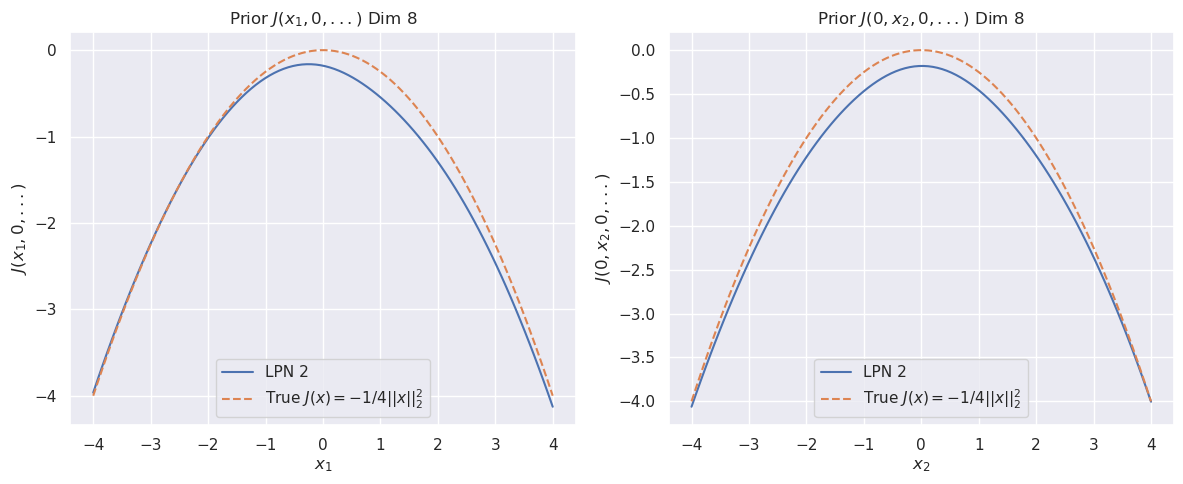

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)